![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)

Today, we'll use neural networks for pneumonia detection! We'll practice creating toy neural networks, apply neural networks (including Convolutional Neural Nets!) to our pneumonia data, and experiment with *transfer learning*: learning from an existing "expert network".

In this notebook we'll be:
1.   Building Neural Networks with Keras
2.   Implementing Transfer Learning
3.   Evalulating our ML models



In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)

def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = shear)
  return augment(data, fun)

def flip_left_right(data):
  fun = augmenters.Fliplr()
  return augment(data, fun)

def flip_up_down(data):
  fun = augmenters.Flipud()
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)

class helpers:
  #### PLOTTING
  def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  #### QUERYING AND COMBINING DATA
  def get_misclassified_data(data, labels, predictions):
    '''
    Gets the data and labels that are misclassified in a classification task
    Returns:
    -missed_data
    -missed_labels
    -predicted_labels (corresponding to missed_labels)
    -missed_index (indices of items in original dataset)
    '''
    missed_index     = np.where(np.abs(predictions.squeeze() - labels.squeeze()) > 0)[0]
    missed_labels    = labels[missed_index]
    missed_data      = data[missed_index,:]
    predicted_labels = predictions[missed_index]
    return missed_data, missed_labels, predicted_labels, missed_index

  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)
    return sms

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry.
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 1)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params, dropout = 0):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.95),
                  metrics=['accuracy'])

    return model

  def evaluate(self, test_data, test_labels):
      loss, accuracy = self.model.evaluate(test_data, test_labels)
      return accuracy
  def train(self, train_data, train_labels, batch_size=32, epochs=10, validation_split=0.2):
      self.models.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

  def CNNClassifier(num_hidden_layers, nn_params, dropout = 0):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(dropout))

    model.add(Dense(units = 64, activation = 'relu'))


    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-4, decay=1e-6)
    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])
    return model
  def evaluate(self, test_data, test_labels):
      loss, accuracy = self.models.evaluate(test_data, test_labels)
      return accuracy
  def fit(self, train_data, train_labels, batch_size=32, epochs=10, validation_split=0.2):
      self.models.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

  def TransferClassifier(name, nn_params, trainable = True):
    expert_dict = {'VGG16': VGG16,
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet',
                                              include_top = False,
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable

    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(64, activation = 'relu'))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'],
                  optimizer = optimizers.SGD(lr=1e-4, momentum=0.95),
                  metrics=['accuracy'])

    return expert_model

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121

from imgaug import augmenters

### defining project variables
# file variables
metadata_url         = "https://storage.googleapis.com/training-labs/metadata.csv"
image_data_url       = 'https://storage.googleapis.com/training-labs/image_data.npy'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
# gdown.download(image_data_url, './image_data.npy', True)
# gdown.download(metadata_url, './metadata.csv', True)
!wget "https://storage.googleapis.com/training-labs/metadata.csv"
!wget "https://storage.googleapis.com/training-labs/image_data.npy"

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
model_to_string        = lambda model: helpers.model_to_string(model)
get_misclassified_data = helpers.get_misclassified_data;
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)

--2023-07-29 05:52:51--  https://storage.googleapis.com/training-labs/metadata.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.250.4.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40508 (40K) [text/csv]
Saving to: ‘metadata.csv’

metadata.csv        100%[===================>]  39.56K  --.-KB/s    in 0s      

2023-07-29 05:52:52 (145 MB/s) - ‘metadata.csv’ saved [40508/40508]

--2023-07-29 05:52:52--  https://storage.googleapis.com/training-labs/image_data.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.250.4.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137625728 (131M) [application/octet-stream]
Saving to: ‘image_data.npy’

image_data.npy      100%[======

# **Milestone 1. Learning Neural Networks**

Now, let's apply neural networks to our medical imaging problem!

### What are neural networks?

Neural networks look something like this:

![A 2 layer neural network](https://cdn-images-1.medium.com/max/1600/1*DW0Ccmj1hZ0OvSXi7Kz5MQ.jpeg)


Each orange and blue node is a neuron. The network itself is composed of a bunch of neurons that talk to each other and eventually give us a prediction. Let's get a bit more concrete with this...

To build neural networks in Python, we use the packages known as `tensorflow` and `keras`.

In [ ]:
# grab tools from our tensorflow and keras toolboxes
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import optimizers

## Exercise (Coding): A 2-Layer Model


We're going to build this model:

![](http://cs231n.github.io/assets/nn1/neural_net.jpeg)

This network can be described as:
* Input Layer: 3
* Layer 1 (Hidden): 4 neurons with the `'relu'` activation function
* Layer 2 (Output): 2 neurons with the `'linear'` activation function

We're going to set up a **Sequential** model by adding on a sequence of layers.

Each layer will be **Dense**, meaning each neuron of the previous layer connects to each neuron of this layer.

We'll compile our model to make it ready to use! We'll use:
- `loss = 'binary_crossentropy'` (how to measure the model's performance while it trains)
- `optimizer = 'adam'` (an algorithm for adjusting the weights)
- `metric = 'accuracy'` (how to measure the model's performance at the end)

Try it out below!

In [ ]:
# Fill in the blanks.
### YOUR CODE HERE:
model_1 = Sequential()
model_1.add(Dense(4, input_shape =(3,), activation = 'relu'))
model_1.add(Dense(2, activation = 'linear'))
model_1.compile(loss='binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])
### END CODE

In [ ]:
#@title Solution { display-mode: "form" }
# Fill in the blanks with your group!
### YOUR CODE HERE:
model_1_answer = Sequential()
model_1_answer.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1_answer.add(Dense(2, activation = 'linear'))
model_1_answer.compile(loss='binary_crossentropy',
optimizer = 'adam',
metrics = ['accuracy'])
model_1 = model_1_answer
### END CODE

In [ ]:
#@title Double-click here if you want to read more detail!
"""
Let's walk though what each of these lines of code means!

**1. Specify model**

```
model = Sequential()
```
In this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it.


**2. Add layers to the network**
```
model.add(Dense(4,input_shape = (3,), activation = 'sigmoid'))
```
In this code, we `add` a `layer` of neurons to our network.

This layers consists of 4 neurons. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layers outputs. We specify that there are 3 inputs here.

We also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use 'softmax' or 'sigmoid'. If you want the neuron to output any number, you can use 'linear'! You'll also often see 'relu', which is when a neuron will only output positive numbers.

```
model.add(Dense(1, activation = 'linear'))
```
This code adds ANOTHER layer to the network that has 1 neuron. This one neuron is used to predict a continuous value!

**3. Turn the model on by compiling it**

After having built the network, we want to train and use it, so we have to 'turn it on' and 'compile' it. To turn it on, we have to specify at the very least, a loss, an optimizer, and some ways of evaluating the model (metrics). Don't worry too much about what this means! Just know that this is necessary.

```
model.compile(loss='mean_squared_error',
optimizer = 'adam',
metrics = ['mean_squared_error'])
  ```
"""

"\nLet's walk though what each of these lines of code means!\n\n**1. Specify model**\n\n```\nmodel = Sequential()\n```\nIn this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it.\n\n\n**2. Add layers to the network**\n```\nmodel.add(Dense(4,input_shape = (3,), activation = 'sigmoid'))\n```\nIn this code, we `add` a `layer` of neurons to our network.\n\nThis layers consists of 4 neurons. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layers outputs. We specify that there are 3 inputs here.\n\nWe also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use 'softmax' or 'sigmoid'. If you want the neuron to output any number, you can use 'linear'! You'll also often see 'relu', w

In [ ]:
#@title Run this to test if your model is right!
model_1_answer = Sequential()
model_1_answer.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1_answer.add(Dense(2, activation = 'linear'))
model_1_answer.compile(loss='binary_crossentropy',
optimizer = 'adam',
metrics = ['accuracy'])

model_1_config = model_1.get_config()

del model_1_config["name"]
for layer in model_1_config["layers"]:
  del layer["config"]["name"]

model_1_answer_config = model_1_answer.get_config()

del model_1_answer_config["name"]
for layer in model_1_answer_config["layers"]:
  del layer["config"]["name"]

if model_1_answer_config == model_1_config:
  print('Good job! Your model worked')
else:
  print('Please check your code again!')

# Old Code
# if model_to_string(model_1) == model_to_string(model_1_answer):
#   print('Good job! Your model worked')
# else:
#   print('Please check your code again!')

Good job! Your model worked


This is a toy example, so we won't train our model with real data - but we can feed in some fake inputs to see what happens! **How many inputs do we need?**


In [ ]:
#YOUR CODE here
from tensorflow.python.ops.gen_array_ops import shape
input_data=tf.random.normal(mean=50, stddev=5, shape=[3,3])

Let's try it out! What do **predict** and **predict_classes** do? How do you interpret the outputs?

In [ ]:
print(model_1.predict(input_data))
print((model_1.predict(input_data) > 0.5).astype("int32"))

1/1 [==============================] - 3s 3s/step
[[-18.393799    -0.17391396]
 [-21.866749    -1.5074496 ]
 [-27.77531     -2.3339663 ]]
1/1 [==============================] - 0s 17ms/step
[[0 0]
 [0 0]
 [0 0]]


In [ ]:
#@title Sample Solution
input_data = [[[3,4,3]]] #Fill in inputs here! How many?

# **Milestone 2. Exploring Neural Networks**

Now, let's apply neural networks to our medical imaging problem!


In our problem, we are given `images` of shape `(64,64,3)`, each assigned a label PNEUMONIA or HEALTHY. We want to identify the key things that we need to design our network.

Understand these points:

* What are our inputs?
* What is/are our outputs?

**Here are the steps to creating a neural network:**

1. Ready the training data/labels and testing data/labels
2. Initiate a model using a certain classifier
3. Train the model using the training data and labels
4. Predict the outputs using the test data
5. Score the model by comparing the test labels with the predictions

**Here is an example of code that creates a neural network, with comments:**

This neural network uses Scikit-learn (used for regression problems). [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) is a type of neural network algorithm, so you can create a simple neural network! Click on the hyperlink to learn more about them if you want.

In [ ]:
#First, import/download any necessary libraries/tools
#In this case, we will import the MLPClassifier algorithm from the sklearn.neural_network library
from sklearn.neural_network import MLPClassifier

#Next, get the data and ready the data
#Neural networks require training data/labels and testing data/labels
#The training data/labels are used to train the models, while the-
#-testing data/labels are used to test how well the model is doing based on its predictions
(train_data, train_labels) = get_train_data(flatten = True);
(test_data, test_labels) = get_test_data(flatten = True);

#Create/initiate the model using a classifier/algorithm
#Here, we set model to the MLPClassifier and input certain arguments
#Note: Always check what the arguments are for algorithms as they vary
model = MLPClassifier(hidden_layer_sizes=(5))

#We train the model using the .fit method
#.fit has arguments (X,y), where X is the features of the training data-
#-and y is the target/labels of the training set
model.fit(train_data,train_labels)

#We make the model predict the target/label values based on the test_data
#Predictions are done with the .predict method
predictions = model.predict(test_data)

#Lastly, score the model based on how accurate its predictions matched the real labels
score = accuracy_score(test_labels, predictions)
print(score)

0.7025


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# **Milestone 3. Diving Deeper into Neural Networks**

Now, let's explore more complex neural networks and apply them to our medical imaging problem.

Let's try out 'Convolutional Neural Networks'! [Convolutional neural networks](https://www.tensorflow.org/tutorials/images/cnn) are networks that process images much like our visual system does. Click on the hyperlink to learn more about them if you want.

We'll use a Keras wrapper that abstracts away the details.

First, let's get our data.



In [ ]:
train_data, train_labels = get_train_data()
test_data, test_labels = get_test_data()

### Creating Models
Now, let's create a model. In fact, let's create two:


**For a "vanilla" neural network:**

```
dense = DenseClassifier(hidden_layer_sizes = (64,32))
```
Arguments:
* hidden_layer_sizes: the number of neurons in each hidden layer
* epochs: the number of times that our network trains on the whole training manual


---


**For a convolutional neural network:**
```
cnn = CNNClassifier(num_hidden_layers = 1)
```
Arguments:
* num_hidden_layers: the number of hidden layers

**Create your models below!** Use any hidden layer sizes you like.

In [ ]:
nn_Params=1
cnn=CNNClassifier(2)

In [ ]:
dense = DenseClassifier(hidden_layer_sizes = (64,32))

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
#@title Sample Solution
dense = DenseClassifier(hidden_layer_sizes = (64,32))
cnn = CNNClassifier(num_hidden_layers = 3)

### Fitting and Scoring
Now, let's fit  our models!

There are default parameters to `.fit` you can call:

```
model_history = model.fit(train_data, train_labels, epochs = 100, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
```

The `shuffle` parameter is important for shuffling the training data before each epoch. The `monitor` callback is used to get a view on internal states and statistics of the model during training. Please don't change these parameters!

**Fit your models below!**

In [ ]:
#YOUR CODE HERE to fit your models
dense_hist = dense.fit(train_data, train_labels, epochs = 20, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
cnn_hist =cnn.fit(train_data, train_labels, epochs = 10, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])


Epoch 1/20


 1/63 [..............................] - ETA: 2:01 - loss: 0.7008 - accuracy: 0.4688

 5/63 [=>............................] - ETA: 0s - loss: 0.6859 - accuracy: 0.4875  

10/63 [===>..........................] - ETA: 0s - loss: 0.6798 - accuracy: 0.5531

14/63 [=====>........................] - ETA: 0s - loss: 0.6762 - accuracy: 0.5714

20/63 [========>.....................] - ETA: 0s - loss: 0.6707 - accuracy: 0.5641

24/63 [==========>...................] - ETA: 0s - loss: 0.6669 - accuracy: 0.5781

29/63 [============>.................] - ETA: 0s - loss: 0.6618 - accuracy: 0.5787

33/63 [==============>...............] - ETA: 0s - loss: 0.6585 - accuracy: 0.5833

38/63 [=================>............] - ETA: 0s - loss: 0.6514 - accuracy: 0.6127

43/63 [===================>..........] - ETA: 0s - loss: 0.6444 - accuracy: 0.6235

46/63 [====================>.........] - ETA: 0s - loss: 0.6423 - accuracy: 0.6298

54/63 [========================>.....] - ETA: 0s - loss: 0.6320 - accuracy: 0.6412

62/63 [============================>.] - ETA: 0s - loss: 0.6230 - accuracy: 0.6573

63/63 [==============================] - 3s 18ms/step - loss: 0.6216 - accuracy: 0.6595 - val_loss: 0.6081 - val_accuracy: 0.6175
Epoch 2/20


 1/63 [..............................] - ETA: 0s - loss: 0.5248 - accuracy: 0.8438

 9/63 [===>..........................] - ETA: 0s - loss: 0.5502 - accuracy: 0.7847

16/63 [======>.......................] - ETA: 0s - loss: 0.5414 - accuracy: 0.7500

24/63 [==========>...................] - ETA: 0s - loss: 0.5294 - accuracy: 0.7604

30/63 [=============>................] - ETA: 0s - loss: 0.5212 - accuracy: 0.7750

37/63 [================>.............] - ETA: 0s - loss: 0.5147 - accuracy: 0.7846

44/63 [===================>..........] - ETA: 0s - loss: 0.5049 - accuracy: 0.7933

52/63 [=======================>......] - ETA: 0s - loss: 0.4960 - accuracy: 0.8023

59/63 [===========================>..] - ETA: 0s - loss: 0.4878 - accuracy: 0.8099

63/63 [==============================] - 1s 11ms/step - loss: 0.4863 - accuracy: 0.8105 - val_loss: 0.5144 - val_accuracy: 0.7250
Epoch 3/20


 1/63 [..............................] - ETA: 0s - loss: 0.3817 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.3898 - accuracy: 0.8711

15/63 [======>.......................] - ETA: 0s - loss: 0.3897 - accuracy: 0.8729

23/63 [=========>....................] - ETA: 0s - loss: 0.3885 - accuracy: 0.8709

31/63 [=============>................] - ETA: 0s - loss: 0.3907 - accuracy: 0.8639

37/63 [================>.............] - ETA: 0s - loss: 0.3876 - accuracy: 0.8615

44/63 [===================>..........] - ETA: 0s - loss: 0.3846 - accuracy: 0.8665

49/63 [======================>.......] - ETA: 0s - loss: 0.3810 - accuracy: 0.8680

56/63 [=========================>....] - ETA: 0s - loss: 0.3816 - accuracy: 0.8661

62/63 [============================>.] - ETA: 0s - loss: 0.3799 - accuracy: 0.8669

63/63 [==============================] - 1s 9ms/step - loss: 0.3798 - accuracy: 0.8670 - val_loss: 0.5157 - val_accuracy: 0.6975
Epoch 4/20


 1/63 [..............................] - ETA: 0s - loss: 0.3586 - accuracy: 0.8750

 7/63 [==>...........................] - ETA: 0s - loss: 0.3516 - accuracy: 0.8795

13/63 [=====>........................] - ETA: 0s - loss: 0.3183 - accuracy: 0.9062

20/63 [========>.....................] - ETA: 0s - loss: 0.3300 - accuracy: 0.8969

26/63 [===========>..................] - ETA: 0s - loss: 0.3312 - accuracy: 0.8978

33/63 [==============>...............] - ETA: 0s - loss: 0.3296 - accuracy: 0.8977

38/63 [=================>............] - ETA: 0s - loss: 0.3300 - accuracy: 0.8923

42/63 [===================>..........] - ETA: 0s - loss: 0.3284 - accuracy: 0.8921

47/63 [=====================>........] - ETA: 0s - loss: 0.3232 - accuracy: 0.8963

52/63 [=======================>......] - ETA: 0s - loss: 0.3196 - accuracy: 0.8966

56/63 [=========================>....] - ETA: 0s - loss: 0.3169 - accuracy: 0.8996

61/63 [============================>.] - ETA: 0s - loss: 0.3152 - accuracy: 0.8996

63/63 [==============================] - 1s 12ms/step - loss: 0.3134 - accuracy: 0.9005 - val_loss: 0.4114 - val_accuracy: 0.8500
Epoch 5/20


 1/63 [..............................] - ETA: 0s - loss: 0.2456 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 0s - loss: 0.2682 - accuracy: 0.9125

 8/63 [==>...........................] - ETA: 0s - loss: 0.2656 - accuracy: 0.9297

14/63 [=====>........................] - ETA: 0s - loss: 0.2666 - accuracy: 0.9263

20/63 [========>.....................] - ETA: 0s - loss: 0.2790 - accuracy: 0.9141

23/63 [=========>....................] - ETA: 0s - loss: 0.2746 - accuracy: 0.9212

28/63 [============>.................] - ETA: 0s - loss: 0.2769 - accuracy: 0.9163

33/63 [==============>...............] - ETA: 0s - loss: 0.2728 - accuracy: 0.9148

40/63 [==================>...........] - ETA: 0s - loss: 0.2737 - accuracy: 0.9109

47/63 [=====================>........] - ETA: 0s - loss: 0.2774 - accuracy: 0.9096

52/63 [=======================>......] - ETA: 0s - loss: 0.2763 - accuracy: 0.9087

59/63 [===========================>..] - ETA: 0s - loss: 0.2752 - accuracy: 0.9089

63/63 [==============================] - 1s 12ms/step - loss: 0.2732 - accuracy: 0.9095 - val_loss: 0.4653 - val_accuracy: 0.7325
Epoch 6/20


 1/63 [..............................] - ETA: 0s - loss: 0.3916 - accuracy: 0.8750

 6/63 [=>............................] - ETA: 0s - loss: 0.2672 - accuracy: 0.9115

12/63 [====>.........................] - ETA: 0s - loss: 0.2438 - accuracy: 0.9141

19/63 [========>.....................] - ETA: 0s - loss: 0.2594 - accuracy: 0.9062

26/63 [===========>..................] - ETA: 0s - loss: 0.2578 - accuracy: 0.9123

33/63 [==============>...............] - ETA: 0s - loss: 0.2530 - accuracy: 0.9100

40/63 [==================>...........] - ETA: 0s - loss: 0.2518 - accuracy: 0.9109

47/63 [=====================>........] - ETA: 0s - loss: 0.2527 - accuracy: 0.9129

54/63 [========================>.....] - ETA: 0s - loss: 0.2582 - accuracy: 0.9080

62/63 [============================>.] - ETA: 0s - loss: 0.2550 - accuracy: 0.9098

63/63 [==============================] - 1s 9ms/step - loss: 0.2546 - accuracy: 0.9100 - val_loss: 0.4510 - val_accuracy: 0.7475
Epoch 7/20


 1/63 [..............................] - ETA: 0s - loss: 0.3041 - accuracy: 0.8750

 6/63 [=>............................] - ETA: 0s - loss: 0.2963 - accuracy: 0.8802

13/63 [=====>........................] - ETA: 0s - loss: 0.2526 - accuracy: 0.9135

18/63 [=======>......................] - ETA: 0s - loss: 0.2630 - accuracy: 0.9062

23/63 [=========>....................] - ETA: 0s - loss: 0.2498 - accuracy: 0.9144

29/63 [============>.................] - ETA: 0s - loss: 0.2470 - accuracy: 0.9159

36/63 [================>.............] - ETA: 0s - loss: 0.2436 - accuracy: 0.9167

41/63 [==================>...........] - ETA: 0s - loss: 0.2408 - accuracy: 0.9154

48/63 [=====================>........] - ETA: 0s - loss: 0.2406 - accuracy: 0.9173

53/63 [========================>.....] - ETA: 0s - loss: 0.2390 - accuracy: 0.9198

57/63 [==========================>...] - ETA: 0s - loss: 0.2405 - accuracy: 0.9183

62/63 [============================>.] - ETA: 0s - loss: 0.2384 - accuracy: 0.9189

63/63 [==============================] - 1s 12ms/step - loss: 0.2374 - accuracy: 0.9195 - val_loss: 0.4429 - val_accuracy: 0.7525
Epoch 8/20


 1/63 [..............................] - ETA: 1s - loss: 0.2037 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.2223 - accuracy: 0.9271

14/63 [=====>........................] - ETA: 0s - loss: 0.2266 - accuracy: 0.9263

18/63 [=======>......................] - ETA: 0s - loss: 0.2259 - accuracy: 0.9253

24/63 [==========>...................] - ETA: 0s - loss: 0.2211 - accuracy: 0.9245

29/63 [============>.................] - ETA: 0s - loss: 0.2251 - accuracy: 0.9235

37/63 [================>.............] - ETA: 0s - loss: 0.2276 - accuracy: 0.9215

45/63 [====================>.........] - ETA: 0s - loss: 0.2255 - accuracy: 0.9215

51/63 [=======================>......] - ETA: 0s - loss: 0.2295 - accuracy: 0.9173

57/63 [==========================>...] - ETA: 0s - loss: 0.2248 - accuracy: 0.9178

63/63 [==============================] - 1s 11ms/step - loss: 0.2206 - accuracy: 0.9200 - val_loss: 0.4131 - val_accuracy: 0.7775
Epoch 9/20


 1/63 [..............................] - ETA: 0s - loss: 0.2906 - accuracy: 0.8750

 6/63 [=>............................] - ETA: 0s - loss: 0.1907 - accuracy: 0.9635

12/63 [====>.........................] - ETA: 0s - loss: 0.2066 - accuracy: 0.9401

18/63 [=======>......................] - ETA: 0s - loss: 0.2013 - accuracy: 0.9410

23/63 [=========>....................] - ETA: 0s - loss: 0.1921 - accuracy: 0.9484

29/63 [============>.................] - ETA: 0s - loss: 0.1965 - accuracy: 0.9450

37/63 [================>.............] - ETA: 0s - loss: 0.2005 - accuracy: 0.9400

42/63 [===================>..........] - ETA: 0s - loss: 0.2041 - accuracy: 0.9360

46/63 [====================>.........] - ETA: 0s - loss: 0.2073 - accuracy: 0.9327

50/63 [======================>.......] - ETA: 0s - loss: 0.2042 - accuracy: 0.9344

55/63 [=========================>....] - ETA: 0s - loss: 0.2037 - accuracy: 0.9347

61/63 [============================>.] - ETA: 0s - loss: 0.2032 - accuracy: 0.9355

63/63 [==============================] - 1s 13ms/step - loss: 0.2053 - accuracy: 0.9340 - val_loss: 0.3885 - val_accuracy: 0.8000
Epoch 10/20


 1/63 [..............................] - ETA: 0s - loss: 0.1945 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.1931 - accuracy: 0.9531

11/63 [====>.........................] - ETA: 0s - loss: 0.1744 - accuracy: 0.9602

16/63 [======>.......................] - ETA: 0s - loss: 0.1697 - accuracy: 0.9531

19/63 [========>.....................] - ETA: 0s - loss: 0.1790 - accuracy: 0.9441

24/63 [==========>...................] - ETA: 0s - loss: 0.1867 - accuracy: 0.9401

29/63 [============>.................] - ETA: 0s - loss: 0.1918 - accuracy: 0.9343

34/63 [===============>..............] - ETA: 0s - loss: 0.1885 - accuracy: 0.9338

39/63 [=================>............] - ETA: 0s - loss: 0.1950 - accuracy: 0.9311

46/63 [====================>.........] - ETA: 0s - loss: 0.1951 - accuracy: 0.9321

52/63 [=======================>......] - ETA: 0s - loss: 0.2002 - accuracy: 0.9309

57/63 [==========================>...] - ETA: 0s - loss: 0.1993 - accuracy: 0.9315

61/63 [============================>.] - ETA: 0s - loss: 0.1985 - accuracy: 0.9308

63/63 [==============================] - 1s 13ms/step - loss: 0.1979 - accuracy: 0.9315 - val_loss: 0.5714 - val_accuracy: 0.7000
Epoch 11/20


 1/63 [..............................] - ETA: 1s - loss: 0.1902 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.1863 - accuracy: 0.9625

11/63 [====>.........................] - ETA: 0s - loss: 0.1946 - accuracy: 0.9489

19/63 [========>.....................] - ETA: 0s - loss: 0.2090 - accuracy: 0.9342

24/63 [==========>...................] - ETA: 0s - loss: 0.1989 - accuracy: 0.9388

30/63 [=============>................] - ETA: 0s - loss: 0.1934 - accuracy: 0.9396

35/63 [===============>..............] - ETA: 0s - loss: 0.1915 - accuracy: 0.9384

40/63 [==================>...........] - ETA: 0s - loss: 0.1883 - accuracy: 0.9414

45/63 [====================>.........] - ETA: 0s - loss: 0.1863 - accuracy: 0.9403

51/63 [=======================>......] - ETA: 0s - loss: 0.1849 - accuracy: 0.9418

56/63 [=========================>....] - ETA: 0s - loss: 0.1855 - accuracy: 0.9414

61/63 [============================>.] - ETA: 0s - loss: 0.1872 - accuracy: 0.9406

63/63 [==============================] - 1s 13ms/step - loss: 0.1903 - accuracy: 0.9395 - val_loss: 0.4479 - val_accuracy: 0.7475
Epoch 12/20


 1/63 [..............................] - ETA: 0s - loss: 0.2339 - accuracy: 0.8750

 6/63 [=>............................] - ETA: 0s - loss: 0.1535 - accuracy: 0.9531

10/63 [===>..........................] - ETA: 0s - loss: 0.1587 - accuracy: 0.9531

13/63 [=====>........................] - ETA: 0s - loss: 0.1724 - accuracy: 0.9423

18/63 [=======>......................] - ETA: 0s - loss: 0.1814 - accuracy: 0.9444

24/63 [==========>...................] - ETA: 0s - loss: 0.1783 - accuracy: 0.9440

29/63 [============>.................] - ETA: 0s - loss: 0.1736 - accuracy: 0.9472

34/63 [===============>..............] - ETA: 0s - loss: 0.1700 - accuracy: 0.9476

38/63 [=================>............] - ETA: 0s - loss: 0.1691 - accuracy: 0.9474

41/63 [==================>...........] - ETA: 0s - loss: 0.1669 - accuracy: 0.9505

46/63 [====================>.........] - ETA: 0s - loss: 0.1729 - accuracy: 0.9443

51/63 [=======================>......] - ETA: 0s - loss: 0.1757 - accuracy: 0.9424

56/63 [=========================>....] - ETA: 0s - loss: 0.1760 - accuracy: 0.9414

62/63 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9390

63/63 [==============================] - 1s 14ms/step - loss: 0.1791 - accuracy: 0.9390 - val_loss: 0.5605 - val_accuracy: 0.7050
Epoch 13/20


 1/63 [..............................] - ETA: 1s - loss: 0.2280 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 0s - loss: 0.1713 - accuracy: 0.9563

 9/63 [===>..........................] - ETA: 0s - loss: 0.1623 - accuracy: 0.9549

15/63 [======>.......................] - ETA: 0s - loss: 0.1575 - accuracy: 0.9521

23/63 [=========>....................] - ETA: 0s - loss: 0.1756 - accuracy: 0.9443

28/63 [============>.................] - ETA: 0s - loss: 0.1708 - accuracy: 0.9442

35/63 [===============>..............] - ETA: 0s - loss: 0.1715 - accuracy: 0.9420

41/63 [==================>...........] - ETA: 0s - loss: 0.1695 - accuracy: 0.9444

48/63 [=====================>........] - ETA: 0s - loss: 0.1711 - accuracy: 0.9447

54/63 [========================>.....] - ETA: 0s - loss: 0.1734 - accuracy: 0.9427

62/63 [============================>.] - ETA: 0s - loss: 0.1738 - accuracy: 0.9430

63/63 [==============================] - 1s 13ms/step - loss: 0.1737 - accuracy: 0.9435 - val_loss: 0.4437 - val_accuracy: 0.7575
Epoch 14/20


 1/63 [..............................] - ETA: 1s - loss: 0.1279 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 0s - loss: 0.1664 - accuracy: 0.9375

16/63 [======>.......................] - ETA: 0s - loss: 0.1654 - accuracy: 0.9375

21/63 [=========>....................] - ETA: 0s - loss: 0.1720 - accuracy: 0.9375

24/63 [==========>...................] - ETA: 0s - loss: 0.1768 - accuracy: 0.9349

29/63 [============>.................] - ETA: 0s - loss: 0.1755 - accuracy: 0.9343

34/63 [===============>..............] - ETA: 0s - loss: 0.1773 - accuracy: 0.9329

39/63 [=================>............] - ETA: 0s - loss: 0.1765 - accuracy: 0.9351

44/63 [===================>..........] - ETA: 0s - loss: 0.1758 - accuracy: 0.9361

49/63 [======================>.......] - ETA: 0s - loss: 0.1771 - accuracy: 0.9349

54/63 [========================>.....] - ETA: 0s - loss: 0.1741 - accuracy: 0.9369

58/63 [==========================>...] - ETA: 0s - loss: 0.1718 - accuracy: 0.9386

62/63 [============================>.] - ETA: 0s - loss: 0.1723 - accuracy: 0.9380

63/63 [==============================] - 1s 14ms/step - loss: 0.1717 - accuracy: 0.9385 - val_loss: 0.4684 - val_accuracy: 0.7375
Epoch 15/20


 1/63 [..............................] - ETA: 1s - loss: 0.1234 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 1s - loss: 0.1183 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 1s - loss: 0.1403 - accuracy: 0.9531

10/63 [===>..........................] - ETA: 0s - loss: 0.1272 - accuracy: 0.9625

14/63 [=====>........................] - ETA: 0s - loss: 0.1472 - accuracy: 0.9554

19/63 [========>.....................] - ETA: 0s - loss: 0.1537 - accuracy: 0.9490

25/63 [==========>...................] - ETA: 0s - loss: 0.1579 - accuracy: 0.9463

32/63 [==============>...............] - ETA: 0s - loss: 0.1637 - accuracy: 0.9453

37/63 [================>.............] - ETA: 0s - loss: 0.1628 - accuracy: 0.9468

43/63 [===================>..........] - ETA: 0s - loss: 0.1613 - accuracy: 0.9462

48/63 [=====================>........] - ETA: 0s - loss: 0.1640 - accuracy: 0.9453

53/63 [========================>.....] - ETA: 0s - loss: 0.1613 - accuracy: 0.9463

59/63 [===========================>..] - ETA: 0s - loss: 0.1604 - accuracy: 0.9476

63/63 [==============================] - 1s 15ms/step - loss: 0.1621 - accuracy: 0.9460 - val_loss: 0.5012 - val_accuracy: 0.7325
Epoch 16/20


 1/63 [..............................] - ETA: 0s - loss: 0.0492 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.1435 - accuracy: 0.9625

10/63 [===>..........................] - ETA: 0s - loss: 0.1528 - accuracy: 0.9531

15/63 [======>.......................] - ETA: 0s - loss: 0.1529 - accuracy: 0.9479

19/63 [========>.....................] - ETA: 0s - loss: 0.1501 - accuracy: 0.9490

23/63 [=========>....................] - ETA: 0s - loss: 0.1604 - accuracy: 0.9443

28/63 [============>.................] - ETA: 0s - loss: 0.1657 - accuracy: 0.9408

33/63 [==============>...............] - ETA: 0s - loss: 0.1732 - accuracy: 0.9366

38/63 [=================>............] - ETA: 0s - loss: 0.1749 - accuracy: 0.9367

43/63 [===================>..........] - ETA: 0s - loss: 0.1668 - accuracy: 0.9419

49/63 [======================>.......] - ETA: 0s - loss: 0.1669 - accuracy: 0.9420

54/63 [========================>.....] - ETA: 0s - loss: 0.1652 - accuracy: 0.9427

60/63 [===========================>..] - ETA: 0s - loss: 0.1617 - accuracy: 0.9448

63/63 [==============================] - 1s 17ms/step - loss: 0.1598 - accuracy: 0.9455 - val_loss: 0.5988 - val_accuracy: 0.7100
Epoch 17/20


 1/63 [..............................] - ETA: 1s - loss: 0.1137 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.1670 - accuracy: 0.9219

 7/63 [==>...........................] - ETA: 0s - loss: 0.1542 - accuracy: 0.9464

11/63 [====>.........................] - ETA: 0s - loss: 0.1590 - accuracy: 0.9489

15/63 [======>.......................] - ETA: 0s - loss: 0.1546 - accuracy: 0.9479

19/63 [========>.....................] - ETA: 0s - loss: 0.1527 - accuracy: 0.9490

23/63 [=========>....................] - ETA: 0s - loss: 0.1467 - accuracy: 0.9524

25/63 [==========>...................] - ETA: 0s - loss: 0.1397 - accuracy: 0.9563

28/63 [============>.................] - ETA: 0s - loss: 0.1413 - accuracy: 0.9542

31/63 [=============>................] - ETA: 0s - loss: 0.1445 - accuracy: 0.9536

36/63 [================>.............] - ETA: 0s - loss: 0.1441 - accuracy: 0.9531

38/63 [=================>............] - ETA: 0s - loss: 0.1421 - accuracy: 0.9548

42/63 [===================>..........] - ETA: 0s - loss: 0.1448 - accuracy: 0.9546

45/63 [====================>.........] - ETA: 0s - loss: 0.1454 - accuracy: 0.9521

48/63 [=====================>........] - ETA: 0s - loss: 0.1445 - accuracy: 0.9538

51/63 [=======================>......] - ETA: 0s - loss: 0.1440 - accuracy: 0.9540

55/63 [=========================>....] - ETA: 0s - loss: 0.1452 - accuracy: 0.9534

58/63 [==========================>...] - ETA: 0s - loss: 0.1488 - accuracy: 0.9504

61/63 [============================>.] - ETA: 0s - loss: 0.1497 - accuracy: 0.9488

63/63 [==============================] - 1s 23ms/step - loss: 0.1511 - accuracy: 0.9475 - val_loss: 0.4265 - val_accuracy: 0.7750
Epoch 18/20


 1/63 [..............................] - ETA: 1s - loss: 0.1175 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.1755 - accuracy: 0.9297

 8/63 [==>...........................] - ETA: 0s - loss: 0.1883 - accuracy: 0.9297

12/63 [====>.........................] - ETA: 0s - loss: 0.1768 - accuracy: 0.9323

16/63 [======>.......................] - ETA: 0s - loss: 0.1738 - accuracy: 0.9414

20/63 [========>.....................] - ETA: 0s - loss: 0.1685 - accuracy: 0.9406

25/63 [==========>...................] - ETA: 0s - loss: 0.1756 - accuracy: 0.9362

30/63 [=============>................] - ETA: 0s - loss: 0.1737 - accuracy: 0.9375

35/63 [===============>..............] - ETA: 0s - loss: 0.1675 - accuracy: 0.9411

42/63 [===================>..........] - ETA: 0s - loss: 0.1634 - accuracy: 0.9420

48/63 [=====================>........] - ETA: 0s - loss: 0.1594 - accuracy: 0.9453

53/63 [========================>.....] - ETA: 0s - loss: 0.1554 - accuracy: 0.9475

57/63 [==========================>...] - ETA: 0s - loss: 0.1543 - accuracy: 0.9468

62/63 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.9496

63/63 [==============================] - 1s 19ms/step - loss: 0.1498 - accuracy: 0.9500 - val_loss: 0.4768 - val_accuracy: 0.7450
Epoch 19/20


 1/63 [..............................] - ETA: 1s - loss: 0.1120 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.1569 - accuracy: 0.9563

 9/63 [===>..........................] - ETA: 0s - loss: 0.1560 - accuracy: 0.9549

13/63 [=====>........................] - ETA: 0s - loss: 0.1494 - accuracy: 0.9519

16/63 [======>.......................] - ETA: 0s - loss: 0.1501 - accuracy: 0.9531

19/63 [========>.....................] - ETA: 0s - loss: 0.1484 - accuracy: 0.9523

24/63 [==========>...................] - ETA: 0s - loss: 0.1375 - accuracy: 0.9570

29/63 [============>.................] - ETA: 0s - loss: 0.1417 - accuracy: 0.9547

35/63 [===============>..............] - ETA: 0s - loss: 0.1538 - accuracy: 0.9473

40/63 [==================>...........] - ETA: 0s - loss: 0.1521 - accuracy: 0.9469

46/63 [====================>.........] - ETA: 0s - loss: 0.1543 - accuracy: 0.9477

51/63 [=======================>......] - ETA: 0s - loss: 0.1511 - accuracy: 0.9485

56/63 [=========================>....] - ETA: 0s - loss: 0.1478 - accuracy: 0.9503

62/63 [============================>.] - ETA: 0s - loss: 0.1486 - accuracy: 0.9481

63/63 [==============================] - 1s 15ms/step - loss: 0.1489 - accuracy: 0.9480 - val_loss: 0.6758 - val_accuracy: 0.6900
Epoch 20/20


 1/63 [..............................] - ETA: 1s - loss: 0.0682 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.1334 - accuracy: 0.9563

 9/63 [===>..........................] - ETA: 0s - loss: 0.1272 - accuracy: 0.9653

14/63 [=====>........................] - ETA: 0s - loss: 0.1407 - accuracy: 0.9531

19/63 [========>.....................] - ETA: 0s - loss: 0.1447 - accuracy: 0.9507

22/63 [=========>....................] - ETA: 0s - loss: 0.1487 - accuracy: 0.9460

28/63 [============>.................] - ETA: 0s - loss: 0.1545 - accuracy: 0.9442

33/63 [==============>...............] - ETA: 0s - loss: 0.1518 - accuracy: 0.9479

39/63 [=================>............] - ETA: 0s - loss: 0.1495 - accuracy: 0.9479

44/63 [===================>..........] - ETA: 0s - loss: 0.1440 - accuracy: 0.9510

49/63 [======================>.......] - ETA: 0s - loss: 0.1423 - accuracy: 0.9522

54/63 [========================>.....] - ETA: 0s - loss: 0.1431 - accuracy: 0.9525

58/63 [==========================>...] - ETA: 0s - loss: 0.1446 - accuracy: 0.9504

63/63 [==============================] - 1s 15ms/step - loss: 0.1414 - accuracy: 0.9520 - val_loss: 0.5858 - val_accuracy: 0.7200
Epoch 1/10


 1/63 [..............................] - ETA: 6:48 - loss: 0.6859 - accuracy: 0.5625

 5/63 [=>............................] - ETA: 0s - loss: 0.7026 - accuracy: 0.4938  

10/63 [===>..........................] - ETA: 0s - loss: 0.6930 - accuracy: 0.5281

15/63 [======>.......................] - ETA: 0s - loss: 0.6845 - accuracy: 0.5813

20/63 [========>.....................] - ETA: 0s - loss: 0.6762 - accuracy: 0.5953

25/63 [==========>...................] - ETA: 0s - loss: 0.6719 - accuracy: 0.5962

30/63 [=============>................] - ETA: 0s - loss: 0.6641 - accuracy: 0.6240

35/63 [===============>..............] - ETA: 0s - loss: 0.6566 - accuracy: 0.6393

40/63 [==================>...........] - ETA: 0s - loss: 0.6482 - accuracy: 0.6547

46/63 [====================>.........] - ETA: 0s - loss: 0.6337 - accuracy: 0.6841

51/63 [=======================>......] - ETA: 0s - loss: 0.6267 - accuracy: 0.6900

57/63 [==========================>...] - ETA: 0s - loss: 0.6158 - accuracy: 0.7045

62/63 [============================>.] - ETA: 0s - loss: 0.6030 - accuracy: 0.7177

63/63 [==============================] - 8s 19ms/step - loss: 0.6025 - accuracy: 0.7185 - val_loss: 0.5203 - val_accuracy: 0.8300
Epoch 2/10


 1/63 [..............................] - ETA: 0s - loss: 0.5079 - accuracy: 0.7812

 6/63 [=>............................] - ETA: 0s - loss: 0.4338 - accuracy: 0.8802

11/63 [====>.........................] - ETA: 0s - loss: 0.4324 - accuracy: 0.8835

16/63 [======>.......................] - ETA: 0s - loss: 0.4356 - accuracy: 0.8613

22/63 [=========>....................] - ETA: 0s - loss: 0.4138 - accuracy: 0.8778

27/63 [===========>..................] - ETA: 0s - loss: 0.4092 - accuracy: 0.8738

33/63 [==============>...............] - ETA: 0s - loss: 0.4015 - accuracy: 0.8750

38/63 [=================>............] - ETA: 0s - loss: 0.3944 - accuracy: 0.8766

44/63 [===================>..........] - ETA: 0s - loss: 0.3954 - accuracy: 0.8672

49/63 [======================>.......] - ETA: 0s - loss: 0.3926 - accuracy: 0.8629

55/63 [=========================>....] - ETA: 0s - loss: 0.3885 - accuracy: 0.8631

61/63 [============================>.] - ETA: 0s - loss: 0.3803 - accuracy: 0.8673

63/63 [==============================] - 1s 12ms/step - loss: 0.3794 - accuracy: 0.8675 - val_loss: 0.5445 - val_accuracy: 0.6825
Epoch 3/10


 1/63 [..............................] - ETA: 0s - loss: 0.3864 - accuracy: 0.8438

 6/63 [=>............................] - ETA: 0s - loss: 0.3324 - accuracy: 0.8854

11/63 [====>.........................] - ETA: 0s - loss: 0.3125 - accuracy: 0.8864

16/63 [======>.......................] - ETA: 0s - loss: 0.3055 - accuracy: 0.8906

21/63 [=========>....................] - ETA: 0s - loss: 0.2901 - accuracy: 0.9048

27/63 [===========>..................] - ETA: 0s - loss: 0.2770 - accuracy: 0.9086

32/63 [==============>...............] - ETA: 0s - loss: 0.2782 - accuracy: 0.9062

37/63 [================>.............] - ETA: 0s - loss: 0.2796 - accuracy: 0.9071

41/63 [==================>...........] - ETA: 0s - loss: 0.2698 - accuracy: 0.9146

45/63 [====================>.........] - ETA: 0s - loss: 0.2716 - accuracy: 0.9139

50/63 [======================>.......] - ETA: 0s - loss: 0.2782 - accuracy: 0.9087

55/63 [=========================>....] - ETA: 0s - loss: 0.2764 - accuracy: 0.9097

60/63 [===========================>..] - ETA: 0s - loss: 0.2728 - accuracy: 0.9109

63/63 [==============================] - 1s 14ms/step - loss: 0.2716 - accuracy: 0.9105 - val_loss: 0.6007 - val_accuracy: 0.6650
Epoch 4/10


 1/63 [..............................] - ETA: 0s - loss: 0.3191 - accuracy: 0.8750

 6/63 [=>............................] - ETA: 0s - loss: 0.2704 - accuracy: 0.8802

11/63 [====>.........................] - ETA: 0s - loss: 0.2503 - accuracy: 0.8949

16/63 [======>.......................] - ETA: 0s - loss: 0.2661 - accuracy: 0.8848

22/63 [=========>....................] - ETA: 0s - loss: 0.2500 - accuracy: 0.8991

27/63 [===========>..................] - ETA: 0s - loss: 0.2365 - accuracy: 0.9086

33/63 [==============>...............] - ETA: 0s - loss: 0.2555 - accuracy: 0.9034

38/63 [=================>............] - ETA: 0s - loss: 0.2498 - accuracy: 0.9046

43/63 [===================>..........] - ETA: 0s - loss: 0.2446 - accuracy: 0.9077

48/63 [=====================>........] - ETA: 0s - loss: 0.2419 - accuracy: 0.9082

53/63 [========================>.....] - ETA: 0s - loss: 0.2401 - accuracy: 0.9086

57/63 [==========================>...] - ETA: 0s - loss: 0.2365 - accuracy: 0.9106

62/63 [============================>.] - ETA: 0s - loss: 0.2297 - accuracy: 0.9148

63/63 [==============================] - 1s 13ms/step - loss: 0.2293 - accuracy: 0.9150 - val_loss: 0.3957 - val_accuracy: 0.8000
Epoch 5/10


 1/63 [..............................] - ETA: 0s - loss: 0.1915 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.2488 - accuracy: 0.9271

11/63 [====>.........................] - ETA: 0s - loss: 0.2335 - accuracy: 0.9290

16/63 [======>.......................] - ETA: 0s - loss: 0.2333 - accuracy: 0.9297

21/63 [=========>....................] - ETA: 0s - loss: 0.2168 - accuracy: 0.9360

26/63 [===========>..................] - ETA: 0s - loss: 0.2178 - accuracy: 0.9279

31/63 [=============>................] - ETA: 0s - loss: 0.2142 - accuracy: 0.9284

36/63 [================>.............] - ETA: 0s - loss: 0.2101 - accuracy: 0.9262

42/63 [===================>..........] - ETA: 0s - loss: 0.2092 - accuracy: 0.9263

47/63 [=====================>........] - ETA: 0s - loss: 0.2005 - accuracy: 0.9322

52/63 [=======================>......] - ETA: 0s - loss: 0.1948 - accuracy: 0.9345

57/63 [==========================>...] - ETA: 0s - loss: 0.1970 - accuracy: 0.9326

63/63 [==============================] - 1s 13ms/step - loss: 0.1920 - accuracy: 0.9345 - val_loss: 0.4230 - val_accuracy: 0.7875
Epoch 6/10


 1/63 [..............................] - ETA: 0s - loss: 0.1472 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.1629 - accuracy: 0.9427

11/63 [====>.........................] - ETA: 0s - loss: 0.1348 - accuracy: 0.9574

16/63 [======>.......................] - ETA: 0s - loss: 0.1438 - accuracy: 0.9531

21/63 [=========>....................] - ETA: 0s - loss: 0.1793 - accuracy: 0.9301

26/63 [===========>..................] - ETA: 0s - loss: 0.1650 - accuracy: 0.9387

31/63 [=============>................] - ETA: 0s - loss: 0.1661 - accuracy: 0.9365

36/63 [================>.............] - ETA: 0s - loss: 0.1644 - accuracy: 0.9375

41/63 [==================>...........] - ETA: 0s - loss: 0.1618 - accuracy: 0.9390

46/63 [====================>.........] - ETA: 0s - loss: 0.1558 - accuracy: 0.9423

51/63 [=======================>......] - ETA: 0s - loss: 0.1561 - accuracy: 0.9406

56/63 [=========================>....] - ETA: 0s - loss: 0.1569 - accuracy: 0.9420

60/63 [===========================>..] - ETA: 0s - loss: 0.1534 - accuracy: 0.9443

63/63 [==============================] - 1s 13ms/step - loss: 0.1561 - accuracy: 0.9430 - val_loss: 0.3579 - val_accuracy: 0.8325
Epoch 7/10


 1/63 [..............................] - ETA: 0s - loss: 0.1862 - accuracy: 0.9062

 6/63 [=>............................] - ETA: 0s - loss: 0.1231 - accuracy: 0.9635

12/63 [====>.........................] - ETA: 0s - loss: 0.1411 - accuracy: 0.9557

17/63 [=======>......................] - ETA: 0s - loss: 0.1325 - accuracy: 0.9559

22/63 [=========>....................] - ETA: 0s - loss: 0.1350 - accuracy: 0.9503

28/63 [============>.................] - ETA: 0s - loss: 0.1395 - accuracy: 0.9487

33/63 [==============>...............] - ETA: 0s - loss: 0.1413 - accuracy: 0.9460

38/63 [=================>............] - ETA: 0s - loss: 0.1449 - accuracy: 0.9465

44/63 [===================>..........] - ETA: 0s - loss: 0.1461 - accuracy: 0.9446

49/63 [======================>.......] - ETA: 0s - loss: 0.1419 - accuracy: 0.9483

55/63 [=========================>....] - ETA: 0s - loss: 0.1440 - accuracy: 0.9483

61/63 [============================>.] - ETA: 0s - loss: 0.1427 - accuracy: 0.9498

63/63 [==============================] - 1s 13ms/step - loss: 0.1430 - accuracy: 0.9490 - val_loss: 0.3048 - val_accuracy: 0.8850
Epoch 8/10


 1/63 [..............................] - ETA: 0s - loss: 0.1614 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.1074 - accuracy: 0.9792

12/63 [====>.........................] - ETA: 0s - loss: 0.1213 - accuracy: 0.9583

17/63 [=======>......................] - ETA: 0s - loss: 0.1345 - accuracy: 0.9504

23/63 [=========>....................] - ETA: 0s - loss: 0.1316 - accuracy: 0.9538

29/63 [============>.................] - ETA: 0s - loss: 0.1352 - accuracy: 0.9494

35/63 [===============>..............] - ETA: 0s - loss: 0.1317 - accuracy: 0.9527

41/63 [==================>...........] - ETA: 0s - loss: 0.1328 - accuracy: 0.9520

47/63 [=====================>........] - ETA: 0s - loss: 0.1345 - accuracy: 0.9508

53/63 [========================>.....] - ETA: 0s - loss: 0.1327 - accuracy: 0.9511

59/63 [===========================>..] - ETA: 0s - loss: 0.1275 - accuracy: 0.9534

63/63 [==============================] - 1s 11ms/step - loss: 0.1305 - accuracy: 0.9520 - val_loss: 0.5957 - val_accuracy: 0.7400
Epoch 9/10


 1/63 [..............................] - ETA: 0s - loss: 0.1007 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0817 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0945 - accuracy: 0.9659

16/63 [======>.......................] - ETA: 0s - loss: 0.0997 - accuracy: 0.9629

21/63 [=========>....................] - ETA: 0s - loss: 0.1131 - accuracy: 0.9568

27/63 [===========>..................] - ETA: 0s - loss: 0.1071 - accuracy: 0.9606

33/63 [==============>...............] - ETA: 0s - loss: 0.1076 - accuracy: 0.9621

38/63 [=================>............] - ETA: 0s - loss: 0.1111 - accuracy: 0.9622

43/63 [===================>..........] - ETA: 0s - loss: 0.1102 - accuracy: 0.9629

49/63 [======================>.......] - ETA: 0s - loss: 0.1138 - accuracy: 0.9624

55/63 [=========================>....] - ETA: 0s - loss: 0.1115 - accuracy: 0.9625

61/63 [============================>.] - ETA: 0s - loss: 0.1150 - accuracy: 0.9600

63/63 [==============================] - 1s 13ms/step - loss: 0.1164 - accuracy: 0.9595 - val_loss: 0.4161 - val_accuracy: 0.8000
Epoch 10/10


 1/63 [..............................] - ETA: 0s - loss: 0.1778 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1184 - accuracy: 0.9598

13/63 [=====>........................] - ETA: 0s - loss: 0.1092 - accuracy: 0.9639

18/63 [=======>......................] - ETA: 0s - loss: 0.1067 - accuracy: 0.9635

24/63 [==========>...................] - ETA: 0s - loss: 0.1049 - accuracy: 0.9635

30/63 [=============>................] - ETA: 0s - loss: 0.1094 - accuracy: 0.9615

35/63 [===============>..............] - ETA: 0s - loss: 0.1104 - accuracy: 0.9598

39/63 [=================>............] - ETA: 0s - loss: 0.1078 - accuracy: 0.9599

44/63 [===================>..........] - ETA: 0s - loss: 0.1053 - accuracy: 0.9609

49/63 [======================>.......] - ETA: 0s - loss: 0.1066 - accuracy: 0.9598

54/63 [========================>.....] - ETA: 0s - loss: 0.1037 - accuracy: 0.9606

59/63 [===========================>..] - ETA: 0s - loss: 0.1082 - accuracy: 0.9582

63/63 [==============================] - 1s 12ms/step - loss: 0.1140 - accuracy: 0.9555 - val_loss: 0.5855 - val_accuracy: 0.7525


In [ ]:
#@title Sample Solution
dense_history = dense.fit(train_data, train_labels, epochs = 20, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
cnn_history =cnn.fit(train_data, train_labels, epochs = 10, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])


###Scoring

Now, let's evaluate our models! To get the scores, you can use:
```
score = model.evaluate(test_data, test_labels, verbose=0)
```

Then `score[0]` will be test loss and `score[1]` will be test accuracy.



In [ ]:
#YOUR CODE HERE to score your models
cnn_acc_score = cnn.evaluate(test_data, test_labels, verbose=0)
dense_acc_score = dense.evaluate(test_data, test_labels, verbose=0)
print ("CNN_SCORE:",cnn_acc_score)
print ("DENSE_SCORE:",dense_acc_score)

CNN_SCORE: [0.5855477452278137, 0.7524999976158142]
DENSE_SCORE: [0.5857580304145813, 0.7200000286102295]


In [ ]:
#@title Sample Solution
cnn_score = cnn.evaluate(test_data, test_labels, verbose=0)
dense_score = dense.evaluate(test_data, test_labels, verbose=0)
print (cnn_score)
print (dense_score)

### Plotting

A great way to understand our model better is to plot the training and test accuracy over time with `plot_acc(model_history)`.

**What do you observe of the training and test accuracy over the training epochs?**

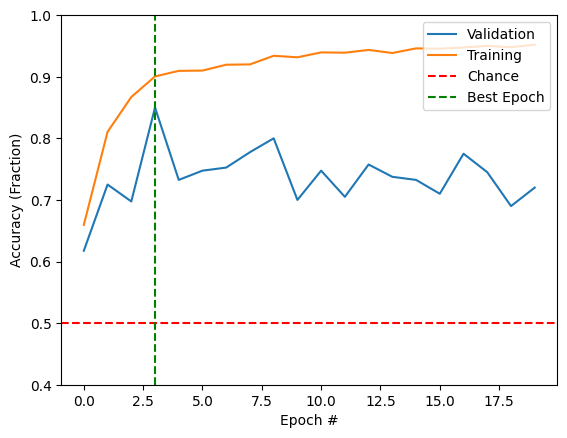

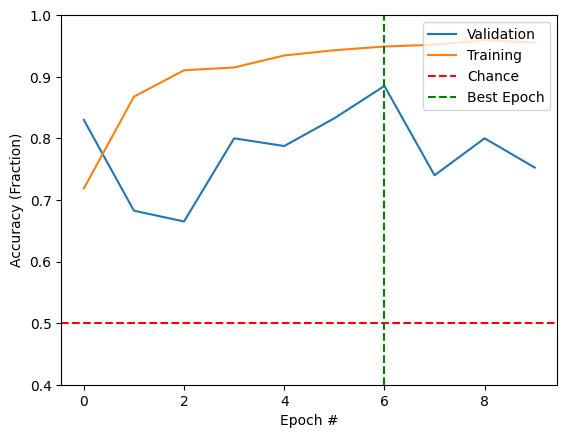

In [ ]:
#YOUR CODE HERE
plot_acc(dense_hist)
plot_acc(cnn_hist)

In [ ]:
#@title Sample Solution
plot_acc(dense_history)
plot_acc(cnn_history)


# **Milestone 4. Expert models: Transfer learning**

For all of the machine learning we've done thus far, we've used models that were built from 'scratch'. All of these models are like newborn babies that have neither seen nor explored the world.

Unfortunately, our training manual is pretty small to all the things in the big wide world. So, just training on our manual is going to be inherently limited.


Luckily, there are **"experts"** who have much more training! While these **"experts"** haven't seen our task, they have experience with a lot of other things. We can hand them our training manual and reasonably expect that they will pick up our task fairly quickly.

In deep learning, the idea of using a model trained on another task as a starting point for your model is known as **transfer learning**.

### VGG 16

For our transfer learning, we're going to use 'experts' built upon the famous 'ImageNet' classification problem.

In ImageNet, participants were challenged to build machine learning models that could distinguish 14 million images' categories, where there were > 20,000 categories available.

Below, we see examples of 4 different categories.

![](http://cs231n.github.io/assets/trainset.jpg)



One of the experts we can use is VGG 16. VGG 16 was a network that was allowed to study the 14 million images 74 times.

After its studying, VGG 16 was able to guess something close to the real label (top-5 accuracy) better than a human can.

![](https://cdn-images-1.medium.com/max/1600/0*V1muWIDnPVwZUuEv.png)

We're going to take an expert model like VGG16 and let it train on OUR x-rays. Hopefully, their experience with those 14 million images will help it understand pneumonia from our x-rays.

### Exercise (Coding)

Let's tap an expert model to help us out with our pneumonia prediction!

We provide a wrapper that lets you 'call' up and employ expert models. You can call it like...

```
transfer = TransferClassifier(name = 'VGG16')
```

The experts we have on hand are:
* `VGG16`
* `VGG19`
* `ResNet50`
* `DenseNet121`

There are default arguments/parameters to model.fit you can call:

`model.fit(train_data, train_labels, epochs = N, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])`

The shuffle parameter is important for shuffling the training data before each epoch. The monitor callback is used to get a view on internal states and statistics of the model during training. Do not change these parameters!

**Experiment with using these experts. Remember to fit and score your model, and to take a look at the training history.**




80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/10


 1/63 [..............................] - ETA: 3:10 - loss: 0.6742 - accuracy: 0.5312

 2/63 [..............................] - ETA: 3s - loss: 0.6810 - accuracy: 0.5156  

 3/63 [>.............................] - ETA: 3s - loss: 0.6972 - accuracy: 0.5104

 4/63 [>.............................] - ETA: 3s - loss: 0.6954 - accuracy: 0.5391

 5/63 [=>............................] - ETA: 3s - loss: 0.6843 - accuracy: 0.5500

 6/63 [=>............................] - ETA: 3s - loss: 0.6777 - accuracy: 0.5729

 7/63 [==>...........................] - ETA: 3s - loss: 0.6685 - accuracy: 0.5982

 8/63 [==>...........................] - ETA: 3s - loss: 0.6649 - accuracy: 0.6016

 9/63 [===>..........................] - ETA: 3s - loss: 0.6658 - accuracy: 0.5972

10/63 [===>..........................] - ETA: 3s - loss: 0.6684 - accuracy: 0.5938

11/63 [====>.........................] - ETA: 3s - loss: 0.6679 - accuracy: 0.5909

12/63 [====>.........................] - ETA: 3s - loss: 0.6628 - accuracy: 0.6016

13/63 [=====>........................] - ETA: 3s - loss: 0.6611 - accuracy: 0.5986

14/63 [=====>........................] - ETA: 2s - loss: 0.6573 - accuracy: 0.5982

15/63 [======>.......................] - ETA: 2s - loss: 0.6542 - accuracy: 0.6042

16/63 [======>.......................] - ETA: 2s - loss: 0.6501 - accuracy: 0.6113

17/63 [=======>......................] - ETA: 2s - loss: 0.6459 - accuracy: 0.6195

18/63 [=======>......................] - ETA: 2s - loss: 0.6430 - accuracy: 0.6302

19/63 [========>.....................] - ETA: 2s - loss: 0.6416 - accuracy: 0.6332

20/63 [========>.....................] - ETA: 2s - loss: 0.6412 - accuracy: 0.6313

21/63 [=========>....................] - ETA: 2s - loss: 0.6382 - accuracy: 0.6369

22/63 [=========>....................] - ETA: 2s - loss: 0.6375 - accuracy: 0.6378

23/63 [=========>....................] - ETA: 2s - loss: 0.6333 - accuracy: 0.6467

24/63 [==========>...................] - ETA: 2s - loss: 0.6276 - accuracy: 0.6576

25/63 [==========>...................] - ETA: 2s - loss: 0.6250 - accuracy: 0.6625

26/63 [===========>..................] - ETA: 2s - loss: 0.6249 - accuracy: 0.6623

27/63 [===========>..................] - ETA: 2s - loss: 0.6207 - accuracy: 0.6690

28/63 [============>.................] - ETA: 2s - loss: 0.6166 - accuracy: 0.6730

29/63 [============>.................] - ETA: 2s - loss: 0.6122 - accuracy: 0.6789

30/63 [=============>................] - ETA: 2s - loss: 0.6086 - accuracy: 0.6823

31/63 [=============>................] - ETA: 1s - loss: 0.6053 - accuracy: 0.6885

32/63 [==============>...............] - ETA: 1s - loss: 0.5995 - accuracy: 0.6943

33/63 [==============>...............] - ETA: 1s - loss: 0.5960 - accuracy: 0.6979

34/63 [===============>..............] - ETA: 1s - loss: 0.5938 - accuracy: 0.7013

35/63 [===============>..............] - ETA: 1s - loss: 0.5895 - accuracy: 0.7071

36/63 [================>.............] - ETA: 1s - loss: 0.5850 - accuracy: 0.7135

37/63 [================>.............] - ETA: 1s - loss: 0.5826 - accuracy: 0.7137

38/63 [=================>............] - ETA: 1s - loss: 0.5788 - accuracy: 0.7171

39/63 [=================>............] - ETA: 1s - loss: 0.5750 - accuracy: 0.7204

40/63 [==================>...........] - ETA: 1s - loss: 0.5732 - accuracy: 0.7211

41/63 [==================>...........] - ETA: 1s - loss: 0.5700 - accuracy: 0.7241

42/63 [===================>..........] - ETA: 1s - loss: 0.5664 - accuracy: 0.7277

43/63 [===================>..........] - ETA: 1s - loss: 0.5640 - accuracy: 0.7318

44/63 [===================>..........] - ETA: 1s - loss: 0.5591 - accuracy: 0.7358

45/63 [====================>.........] - ETA: 1s - loss: 0.5535 - accuracy: 0.7389

46/63 [====================>.........] - ETA: 1s - loss: 0.5485 - accuracy: 0.7412

47/63 [=====================>........] - ETA: 0s - loss: 0.5479 - accuracy: 0.7420

48/63 [=====================>........] - ETA: 0s - loss: 0.5450 - accuracy: 0.7435

49/63 [======================>.......] - ETA: 0s - loss: 0.5384 - accuracy: 0.7487

50/63 [======================>.......] - ETA: 0s - loss: 0.5361 - accuracy: 0.7513

51/63 [=======================>......] - ETA: 0s - loss: 0.5301 - accuracy: 0.7549

52/63 [=======================>......] - ETA: 0s - loss: 0.5257 - accuracy: 0.7578

53/63 [========================>.....] - ETA: 0s - loss: 0.5224 - accuracy: 0.7606

54/63 [========================>.....] - ETA: 0s - loss: 0.5187 - accuracy: 0.7627

55/63 [=========================>....] - ETA: 0s - loss: 0.5134 - accuracy: 0.7665

56/63 [=========================>....] - ETA: 0s - loss: 0.5086 - accuracy: 0.7701

57/63 [==========================>...] - ETA: 0s - loss: 0.5048 - accuracy: 0.7725

58/63 [==========================>...] - ETA: 0s - loss: 0.4995 - accuracy: 0.7748

59/63 [===========================>..] - ETA: 0s - loss: 0.4970 - accuracy: 0.7765

60/63 [===========================>..] - ETA: 0s - loss: 0.4926 - accuracy: 0.7797

61/63 [============================>.] - ETA: 0s - loss: 0.4889 - accuracy: 0.7812

62/63 [============================>.] - ETA: 0s - loss: 0.4827 - accuracy: 0.7848

63/63 [==============================] - 8s 87ms/step - loss: 0.4806 - accuracy: 0.7865 - val_loss: 0.4651 - val_accuracy: 0.7850
Epoch 2/10


 1/63 [..............................] - ETA: 3s - loss: 0.4187 - accuracy: 0.8438

 2/63 [..............................] - ETA: 3s - loss: 0.3070 - accuracy: 0.8906

 3/63 [>.............................] - ETA: 3s - loss: 0.2669 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 3s - loss: 0.2620 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 3s - loss: 0.2486 - accuracy: 0.9125

 6/63 [=>............................] - ETA: 3s - loss: 0.2306 - accuracy: 0.9167

 7/63 [==>...........................] - ETA: 3s - loss: 0.2263 - accuracy: 0.9107

 8/63 [==>...........................] - ETA: 3s - loss: 0.2250 - accuracy: 0.9102

 9/63 [===>..........................] - ETA: 3s - loss: 0.2492 - accuracy: 0.9028

10/63 [===>..........................] - ETA: 3s - loss: 0.2660 - accuracy: 0.8969

11/63 [====>.........................] - ETA: 3s - loss: 0.2583 - accuracy: 0.9006

12/63 [====>.........................] - ETA: 3s - loss: 0.2458 - accuracy: 0.9062

13/63 [=====>........................] - ETA: 3s - loss: 0.2342 - accuracy: 0.9111

14/63 [=====>........................] - ETA: 3s - loss: 0.2366 - accuracy: 0.9129

15/63 [======>.......................] - ETA: 2s - loss: 0.2353 - accuracy: 0.9125

16/63 [======>.......................] - ETA: 2s - loss: 0.2285 - accuracy: 0.9141

17/63 [=======>......................] - ETA: 2s - loss: 0.2266 - accuracy: 0.9136

18/63 [=======>......................] - ETA: 2s - loss: 0.2244 - accuracy: 0.9149

19/63 [========>.....................] - ETA: 2s - loss: 0.2157 - accuracy: 0.9194

20/63 [========>.....................] - ETA: 2s - loss: 0.2135 - accuracy: 0.9203

21/63 [=========>....................] - ETA: 2s - loss: 0.2120 - accuracy: 0.9196

22/63 [=========>....................] - ETA: 2s - loss: 0.2063 - accuracy: 0.9219

23/63 [=========>....................] - ETA: 2s - loss: 0.2071 - accuracy: 0.9226

24/63 [==========>...................] - ETA: 2s - loss: 0.2056 - accuracy: 0.9232

25/63 [==========>...................] - ETA: 2s - loss: 0.2048 - accuracy: 0.9225

26/63 [===========>..................] - ETA: 2s - loss: 0.2113 - accuracy: 0.9207

27/63 [===========>..................] - ETA: 2s - loss: 0.2103 - accuracy: 0.9213

28/63 [============>.................] - ETA: 2s - loss: 0.2052 - accuracy: 0.9241

29/63 [============>.................] - ETA: 2s - loss: 0.2123 - accuracy: 0.9224

30/63 [=============>................] - ETA: 2s - loss: 0.2190 - accuracy: 0.9187

31/63 [=============>................] - ETA: 1s - loss: 0.2187 - accuracy: 0.9194

32/63 [==============>...............] - ETA: 1s - loss: 0.2188 - accuracy: 0.9189

33/63 [==============>...............] - ETA: 1s - loss: 0.2176 - accuracy: 0.9186

34/63 [===============>..............] - ETA: 1s - loss: 0.2181 - accuracy: 0.9191

35/63 [===============>..............] - ETA: 1s - loss: 0.2163 - accuracy: 0.9196

36/63 [================>.............] - ETA: 1s - loss: 0.2119 - accuracy: 0.9219

37/63 [================>.............] - ETA: 1s - loss: 0.2072 - accuracy: 0.9240

38/63 [=================>............] - ETA: 1s - loss: 0.2065 - accuracy: 0.9243

39/63 [=================>............] - ETA: 1s - loss: 0.2070 - accuracy: 0.9223

40/63 [==================>...........] - ETA: 1s - loss: 0.2037 - accuracy: 0.9234

41/63 [==================>...........] - ETA: 1s - loss: 0.2017 - accuracy: 0.9238

42/63 [===================>..........] - ETA: 1s - loss: 0.2009 - accuracy: 0.9241

43/63 [===================>..........] - ETA: 1s - loss: 0.1993 - accuracy: 0.9251

44/63 [===================>..........] - ETA: 1s - loss: 0.1966 - accuracy: 0.9268

45/63 [====================>.........] - ETA: 1s - loss: 0.1942 - accuracy: 0.9278

46/63 [====================>.........] - ETA: 1s - loss: 0.1924 - accuracy: 0.9287

47/63 [=====================>........] - ETA: 0s - loss: 0.1894 - accuracy: 0.9302

48/63 [=====================>........] - ETA: 0s - loss: 0.1915 - accuracy: 0.9277

49/63 [======================>.......] - ETA: 0s - loss: 0.1891 - accuracy: 0.9286

50/63 [======================>.......] - ETA: 0s - loss: 0.1880 - accuracy: 0.9281

51/63 [=======================>......] - ETA: 0s - loss: 0.1852 - accuracy: 0.9295

52/63 [=======================>......] - ETA: 0s - loss: 0.1825 - accuracy: 0.9309

53/63 [========================>.....] - ETA: 0s - loss: 0.1838 - accuracy: 0.9310

54/63 [========================>.....] - ETA: 0s - loss: 0.1811 - accuracy: 0.9323

55/63 [=========================>....] - ETA: 0s - loss: 0.1800 - accuracy: 0.9324

56/63 [=========================>....] - ETA: 0s - loss: 0.1789 - accuracy: 0.9330

57/63 [==========================>...] - ETA: 0s - loss: 0.1780 - accuracy: 0.9331

58/63 [==========================>...] - ETA: 0s - loss: 0.1755 - accuracy: 0.9343

59/63 [===========================>..] - ETA: 0s - loss: 0.1729 - accuracy: 0.9354

60/63 [===========================>..] - ETA: 0s - loss: 0.1713 - accuracy: 0.9359

61/63 [============================>.] - ETA: 0s - loss: 0.1735 - accuracy: 0.9344

62/63 [============================>.] - ETA: 0s - loss: 0.1712 - accuracy: 0.9355

63/63 [==============================] - 4s 67ms/step - loss: 0.1714 - accuracy: 0.9350 - val_loss: 0.4279 - val_accuracy: 0.8425
Epoch 3/10


 1/63 [..............................] - ETA: 3s - loss: 0.0718 - accuracy: 0.9688

 2/63 [..............................] - ETA: 4s - loss: 0.1111 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 3s - loss: 0.0883 - accuracy: 0.9792

 4/63 [>.............................] - ETA: 3s - loss: 0.1056 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 3s - loss: 0.1002 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 3s - loss: 0.1113 - accuracy: 0.9635

 7/63 [==>...........................] - ETA: 3s - loss: 0.1047 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 3s - loss: 0.1037 - accuracy: 0.9648

 9/63 [===>..........................] - ETA: 3s - loss: 0.0980 - accuracy: 0.9653

10/63 [===>..........................] - ETA: 3s - loss: 0.1089 - accuracy: 0.9656

11/63 [====>.........................] - ETA: 3s - loss: 0.1265 - accuracy: 0.9631

12/63 [====>.........................] - ETA: 3s - loss: 0.1312 - accuracy: 0.9609

13/63 [=====>........................] - ETA: 3s - loss: 0.1350 - accuracy: 0.9543

14/63 [=====>........................] - ETA: 3s - loss: 0.1271 - accuracy: 0.9576

15/63 [======>.......................] - ETA: 3s - loss: 0.1234 - accuracy: 0.9583

16/63 [======>.......................] - ETA: 3s - loss: 0.1194 - accuracy: 0.9609

17/63 [=======>......................] - ETA: 2s - loss: 0.1451 - accuracy: 0.9540

18/63 [=======>......................] - ETA: 2s - loss: 0.1425 - accuracy: 0.9531

19/63 [========>.....................] - ETA: 2s - loss: 0.1392 - accuracy: 0.9539

20/63 [========>.....................] - ETA: 2s - loss: 0.1420 - accuracy: 0.9516

21/63 [=========>....................] - ETA: 2s - loss: 0.1407 - accuracy: 0.9509

22/63 [=========>....................] - ETA: 2s - loss: 0.1496 - accuracy: 0.9474

23/63 [=========>....................] - ETA: 2s - loss: 0.1559 - accuracy: 0.9416

24/63 [==========>...................] - ETA: 2s - loss: 0.1530 - accuracy: 0.9414

25/63 [==========>...................] - ETA: 2s - loss: 0.1503 - accuracy: 0.9438

26/63 [===========>..................] - ETA: 2s - loss: 0.1539 - accuracy: 0.9423

27/63 [===========>..................] - ETA: 2s - loss: 0.1530 - accuracy: 0.9421

28/63 [============>.................] - ETA: 2s - loss: 0.1562 - accuracy: 0.9397

29/63 [============>.................] - ETA: 2s - loss: 0.1531 - accuracy: 0.9418

30/63 [=============>................] - ETA: 2s - loss: 0.1499 - accuracy: 0.9438

31/63 [=============>................] - ETA: 2s - loss: 0.1483 - accuracy: 0.9446

32/63 [==============>...............] - ETA: 1s - loss: 0.1470 - accuracy: 0.9443

33/63 [==============>...............] - ETA: 1s - loss: 0.1453 - accuracy: 0.9451

34/63 [===============>..............] - ETA: 1s - loss: 0.1487 - accuracy: 0.9439

35/63 [===============>..............] - ETA: 1s - loss: 0.1487 - accuracy: 0.9446

36/63 [================>.............] - ETA: 1s - loss: 0.1505 - accuracy: 0.9444

37/63 [================>.............] - ETA: 1s - loss: 0.1476 - accuracy: 0.9459

38/63 [=================>............] - ETA: 1s - loss: 0.1449 - accuracy: 0.9474

39/63 [=================>............] - ETA: 1s - loss: 0.1423 - accuracy: 0.9487

40/63 [==================>...........] - ETA: 1s - loss: 0.1402 - accuracy: 0.9492

41/63 [==================>...........] - ETA: 1s - loss: 0.1441 - accuracy: 0.9489

42/63 [===================>..........] - ETA: 1s - loss: 0.1442 - accuracy: 0.9487

43/63 [===================>..........] - ETA: 1s - loss: 0.1446 - accuracy: 0.9477

44/63 [===================>..........] - ETA: 1s - loss: 0.1428 - accuracy: 0.9489

45/63 [====================>.........] - ETA: 1s - loss: 0.1411 - accuracy: 0.9500

46/63 [====================>.........] - ETA: 1s - loss: 0.1391 - accuracy: 0.9511

47/63 [=====================>........] - ETA: 1s - loss: 0.1402 - accuracy: 0.9508

48/63 [=====================>........] - ETA: 0s - loss: 0.1397 - accuracy: 0.9512

49/63 [======================>.......] - ETA: 0s - loss: 0.1396 - accuracy: 0.9515

50/63 [======================>.......] - ETA: 0s - loss: 0.1427 - accuracy: 0.9506

51/63 [=======================>......] - ETA: 0s - loss: 0.1424 - accuracy: 0.9504

52/63 [=======================>......] - ETA: 0s - loss: 0.1402 - accuracy: 0.9513

53/63 [========================>.....] - ETA: 0s - loss: 0.1385 - accuracy: 0.9522

54/63 [========================>.....] - ETA: 0s - loss: 0.1376 - accuracy: 0.9520

55/63 [=========================>....] - ETA: 0s - loss: 0.1371 - accuracy: 0.9523

56/63 [=========================>....] - ETA: 0s - loss: 0.1386 - accuracy: 0.9515

57/63 [==========================>...] - ETA: 0s - loss: 0.1379 - accuracy: 0.9518

58/63 [==========================>...] - ETA: 0s - loss: 0.1378 - accuracy: 0.9520

59/63 [===========================>..] - ETA: 0s - loss: 0.1369 - accuracy: 0.9523

60/63 [===========================>..] - ETA: 0s - loss: 0.1352 - accuracy: 0.9531

61/63 [============================>.] - ETA: 0s - loss: 0.1372 - accuracy: 0.9524

62/63 [============================>.] - ETA: 0s - loss: 0.1369 - accuracy: 0.9526

63/63 [==============================] - 4s 68ms/step - loss: 0.1380 - accuracy: 0.9525 - val_loss: 0.4869 - val_accuracy: 0.8225
Epoch 4/10


 1/63 [..............................] - ETA: 3s - loss: 0.0342 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.1425 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 3s - loss: 0.1678 - accuracy: 0.9375

 4/63 [>.............................] - ETA: 3s - loss: 0.1345 - accuracy: 0.9531

 5/63 [=>............................] - ETA: 3s - loss: 0.1155 - accuracy: 0.9625

 6/63 [=>............................] - ETA: 3s - loss: 0.1086 - accuracy: 0.9583

 7/63 [==>...........................] - ETA: 3s - loss: 0.1050 - accuracy: 0.9598

 8/63 [==>...........................] - ETA: 3s - loss: 0.0963 - accuracy: 0.9648

 9/63 [===>..........................] - ETA: 3s - loss: 0.0952 - accuracy: 0.9653

10/63 [===>..........................] - ETA: 3s - loss: 0.0906 - accuracy: 0.9656

11/63 [====>.........................] - ETA: 3s - loss: 0.0949 - accuracy: 0.9659

12/63 [====>.........................] - ETA: 3s - loss: 0.0917 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 3s - loss: 0.0935 - accuracy: 0.9688

14/63 [=====>........................] - ETA: 3s - loss: 0.0886 - accuracy: 0.9710

15/63 [======>.......................] - ETA: 3s - loss: 0.0881 - accuracy: 0.9688

16/63 [======>.......................] - ETA: 2s - loss: 0.0907 - accuracy: 0.9688

17/63 [=======>......................] - ETA: 2s - loss: 0.0861 - accuracy: 0.9706

18/63 [=======>......................] - ETA: 2s - loss: 0.0848 - accuracy: 0.9722

19/63 [========>.....................] - ETA: 2s - loss: 0.0827 - accuracy: 0.9737

20/63 [========>.....................] - ETA: 2s - loss: 0.0806 - accuracy: 0.9750

21/63 [=========>....................] - ETA: 2s - loss: 0.0840 - accuracy: 0.9732

22/63 [=========>....................] - ETA: 2s - loss: 0.0817 - accuracy: 0.9744

23/63 [=========>....................] - ETA: 2s - loss: 0.0856 - accuracy: 0.9715

24/63 [==========>...................] - ETA: 2s - loss: 0.0850 - accuracy: 0.9714

25/63 [==========>...................] - ETA: 2s - loss: 0.0829 - accuracy: 0.9725

26/63 [===========>..................] - ETA: 2s - loss: 0.0810 - accuracy: 0.9736

27/63 [===========>..................] - ETA: 2s - loss: 0.0811 - accuracy: 0.9722

28/63 [============>.................] - ETA: 2s - loss: 0.0790 - accuracy: 0.9732

29/63 [============>.................] - ETA: 2s - loss: 0.0775 - accuracy: 0.9741

30/63 [=============>................] - ETA: 2s - loss: 0.0763 - accuracy: 0.9750

31/63 [=============>................] - ETA: 2s - loss: 0.0746 - accuracy: 0.9758

32/63 [==============>...............] - ETA: 1s - loss: 0.0752 - accuracy: 0.9756

33/63 [==============>...............] - ETA: 1s - loss: 0.0750 - accuracy: 0.9754

34/63 [===============>..............] - ETA: 1s - loss: 0.0765 - accuracy: 0.9743

35/63 [===============>..............] - ETA: 1s - loss: 0.0750 - accuracy: 0.9750

36/63 [================>.............] - ETA: 1s - loss: 0.0735 - accuracy: 0.9757

37/63 [================>.............] - ETA: 1s - loss: 0.0726 - accuracy: 0.9764

38/63 [=================>............] - ETA: 1s - loss: 0.0757 - accuracy: 0.9753

39/63 [=================>............] - ETA: 1s - loss: 0.0749 - accuracy: 0.9752

40/63 [==================>...........] - ETA: 1s - loss: 0.0762 - accuracy: 0.9750

41/63 [==================>...........] - ETA: 1s - loss: 0.0753 - accuracy: 0.9748

42/63 [===================>..........] - ETA: 1s - loss: 0.0746 - accuracy: 0.9747

43/63 [===================>..........] - ETA: 1s - loss: 0.0745 - accuracy: 0.9746

44/63 [===================>..........] - ETA: 1s - loss: 0.0746 - accuracy: 0.9737

45/63 [====================>.........] - ETA: 1s - loss: 0.0753 - accuracy: 0.9736

46/63 [====================>.........] - ETA: 1s - loss: 0.0746 - accuracy: 0.9735

47/63 [=====================>........] - ETA: 1s - loss: 0.0741 - accuracy: 0.9734

48/63 [=====================>........] - ETA: 0s - loss: 0.0735 - accuracy: 0.9733

49/63 [======================>.......] - ETA: 0s - loss: 0.0740 - accuracy: 0.9732

50/63 [======================>.......] - ETA: 0s - loss: 0.0727 - accuracy: 0.9737

51/63 [=======================>......] - ETA: 0s - loss: 0.0759 - accuracy: 0.9730

52/63 [=======================>......] - ETA: 0s - loss: 0.0800 - accuracy: 0.9730

53/63 [========================>.....] - ETA: 0s - loss: 0.0811 - accuracy: 0.9729

54/63 [========================>.....] - ETA: 0s - loss: 0.0807 - accuracy: 0.9728

55/63 [=========================>....] - ETA: 0s - loss: 0.0794 - accuracy: 0.9733

56/63 [=========================>....] - ETA: 0s - loss: 0.0809 - accuracy: 0.9727

57/63 [==========================>...] - ETA: 0s - loss: 0.0797 - accuracy: 0.9731

58/63 [==========================>...] - ETA: 0s - loss: 0.0793 - accuracy: 0.9731

59/63 [===========================>..] - ETA: 0s - loss: 0.0792 - accuracy: 0.9730

60/63 [===========================>..] - ETA: 0s - loss: 0.0842 - accuracy: 0.9719

61/63 [============================>.] - ETA: 0s - loss: 0.0880 - accuracy: 0.9703

62/63 [============================>.] - ETA: 0s - loss: 0.0875 - accuracy: 0.9703

63/63 [==============================] - 4s 68ms/step - loss: 0.0873 - accuracy: 0.9700 - val_loss: 0.6986 - val_accuracy: 0.7950
Epoch 5/10


 1/63 [..............................] - ETA: 4s - loss: 0.0692 - accuracy: 0.9688

 2/63 [..............................] - ETA: 4s - loss: 0.0693 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 4s - loss: 0.0529 - accuracy: 0.9792

 4/63 [>.............................] - ETA: 4s - loss: 0.0996 - accuracy: 0.9609

 5/63 [=>............................] - ETA: 4s - loss: 0.0950 - accuracy: 0.9563

 6/63 [=>............................] - ETA: 3s - loss: 0.0921 - accuracy: 0.9531

 7/63 [==>...........................] - ETA: 3s - loss: 0.0849 - accuracy: 0.9598

 8/63 [==>...........................] - ETA: 3s - loss: 0.0756 - accuracy: 0.9648

 9/63 [===>..........................] - ETA: 3s - loss: 0.0949 - accuracy: 0.9583

10/63 [===>..........................] - ETA: 3s - loss: 0.0901 - accuracy: 0.9594

11/63 [====>.........................] - ETA: 3s - loss: 0.0938 - accuracy: 0.9574

12/63 [====>.........................] - ETA: 3s - loss: 0.0876 - accuracy: 0.9609

13/63 [=====>........................] - ETA: 3s - loss: 0.0859 - accuracy: 0.9615

14/63 [=====>........................] - ETA: 3s - loss: 0.0813 - accuracy: 0.9643

15/63 [======>.......................] - ETA: 3s - loss: 0.0810 - accuracy: 0.9646

16/63 [======>.......................] - ETA: 3s - loss: 0.0815 - accuracy: 0.9648

17/63 [=======>......................] - ETA: 3s - loss: 0.0785 - accuracy: 0.9669

18/63 [=======>......................] - ETA: 3s - loss: 0.0850 - accuracy: 0.9670

19/63 [========>.....................] - ETA: 3s - loss: 0.0853 - accuracy: 0.9671

20/63 [========>.....................] - ETA: 2s - loss: 0.0827 - accuracy: 0.9688

21/63 [=========>....................] - ETA: 2s - loss: 0.0801 - accuracy: 0.9702

22/63 [=========>....................] - ETA: 2s - loss: 0.0823 - accuracy: 0.9702

23/63 [=========>....................] - ETA: 2s - loss: 0.0810 - accuracy: 0.9688

24/63 [==========>...................] - ETA: 2s - loss: 0.0834 - accuracy: 0.9674

25/63 [==========>...................] - ETA: 2s - loss: 0.0806 - accuracy: 0.9688

26/63 [===========>..................] - ETA: 2s - loss: 0.0848 - accuracy: 0.9675

27/63 [===========>..................] - ETA: 2s - loss: 0.0920 - accuracy: 0.9653

28/63 [============>.................] - ETA: 2s - loss: 0.0897 - accuracy: 0.9665

29/63 [============>.................] - ETA: 2s - loss: 0.0951 - accuracy: 0.9655

30/63 [=============>................] - ETA: 2s - loss: 0.0957 - accuracy: 0.9656

31/63 [=============>................] - ETA: 2s - loss: 0.0950 - accuracy: 0.9657

32/63 [==============>...............] - ETA: 2s - loss: 0.0934 - accuracy: 0.9668

33/63 [==============>...............] - ETA: 2s - loss: 0.0994 - accuracy: 0.9650

34/63 [===============>..............] - ETA: 1s - loss: 0.1038 - accuracy: 0.9623

35/63 [===============>..............] - ETA: 1s - loss: 0.1048 - accuracy: 0.9616

36/63 [================>.............] - ETA: 1s - loss: 0.1044 - accuracy: 0.9618

37/63 [================>.............] - ETA: 1s - loss: 0.1024 - accuracy: 0.9628

38/63 [=================>............] - ETA: 1s - loss: 0.1041 - accuracy: 0.9613

39/63 [=================>............] - ETA: 1s - loss: 0.1040 - accuracy: 0.9615

40/63 [==================>...........] - ETA: 1s - loss: 0.1078 - accuracy: 0.9602

41/63 [==================>...........] - ETA: 1s - loss: 0.1072 - accuracy: 0.9604

42/63 [===================>..........] - ETA: 1s - loss: 0.1065 - accuracy: 0.9606

43/63 [===================>..........] - ETA: 1s - loss: 0.1084 - accuracy: 0.9593

44/63 [===================>..........] - ETA: 1s - loss: 0.1070 - accuracy: 0.9602

45/63 [====================>.........] - ETA: 1s - loss: 0.1067 - accuracy: 0.9604

46/63 [====================>.........] - ETA: 1s - loss: 0.1069 - accuracy: 0.9606

47/63 [=====================>........] - ETA: 1s - loss: 0.1073 - accuracy: 0.9601

48/63 [=====================>........] - ETA: 0s - loss: 0.1119 - accuracy: 0.9577

49/63 [======================>.......] - ETA: 0s - loss: 0.1182 - accuracy: 0.9547

50/63 [======================>.......] - ETA: 0s - loss: 0.1179 - accuracy: 0.9550

51/63 [=======================>......] - ETA: 0s - loss: 0.1188 - accuracy: 0.9547

52/63 [=======================>......] - ETA: 0s - loss: 0.1218 - accuracy: 0.9537

53/63 [========================>.....] - ETA: 0s - loss: 0.1256 - accuracy: 0.9528

54/63 [========================>.....] - ETA: 0s - loss: 0.1310 - accuracy: 0.9508

55/63 [=========================>....] - ETA: 0s - loss: 0.1299 - accuracy: 0.9511

56/63 [=========================>....] - ETA: 0s - loss: 0.1331 - accuracy: 0.9503

57/63 [==========================>...] - ETA: 0s - loss: 0.1333 - accuracy: 0.9501

58/63 [==========================>...] - ETA: 0s - loss: 0.1316 - accuracy: 0.9510

59/63 [===========================>..] - ETA: 0s - loss: 0.1310 - accuracy: 0.9507

60/63 [===========================>..] - ETA: 0s - loss: 0.1324 - accuracy: 0.9495

61/63 [============================>.] - ETA: 0s - loss: 0.1313 - accuracy: 0.9498

62/63 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.9506

63/63 [==============================] - 4s 69ms/step - loss: 0.1300 - accuracy: 0.9510 - val_loss: 1.1374 - val_accuracy: 0.6200
Epoch 6/10


 1/63 [..............................] - ETA: 3s - loss: 0.1053 - accuracy: 0.9688

 2/63 [..............................] - ETA: 3s - loss: 0.1168 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 3s - loss: 0.1276 - accuracy: 0.9583

 4/63 [>.............................] - ETA: 3s - loss: 0.1269 - accuracy: 0.9531

 5/63 [=>............................] - ETA: 3s - loss: 0.1129 - accuracy: 0.9625

 6/63 [=>............................] - ETA: 3s - loss: 0.0985 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 3s - loss: 0.1002 - accuracy: 0.9643

 8/63 [==>...........................] - ETA: 3s - loss: 0.0926 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 3s - loss: 0.0905 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 3s - loss: 0.1013 - accuracy: 0.9656

11/63 [====>.........................] - ETA: 3s - loss: 0.1072 - accuracy: 0.9631

12/63 [====>.........................] - ETA: 3s - loss: 0.1092 - accuracy: 0.9635

13/63 [=====>........................] - ETA: 3s - loss: 0.1077 - accuracy: 0.9639

14/63 [=====>........................] - ETA: 3s - loss: 0.1108 - accuracy: 0.9598

15/63 [======>.......................] - ETA: 3s - loss: 0.1099 - accuracy: 0.9604

16/63 [======>.......................] - ETA: 2s - loss: 0.1047 - accuracy: 0.9629

17/63 [=======>......................] - ETA: 2s - loss: 0.1033 - accuracy: 0.9632

18/63 [=======>......................] - ETA: 2s - loss: 0.1000 - accuracy: 0.9653

19/63 [========>.....................] - ETA: 2s - loss: 0.1028 - accuracy: 0.9655

20/63 [========>.....................] - ETA: 2s - loss: 0.0994 - accuracy: 0.9672

21/63 [=========>....................] - ETA: 2s - loss: 0.1024 - accuracy: 0.9658

22/63 [=========>....................] - ETA: 2s - loss: 0.1039 - accuracy: 0.9659

23/63 [=========>....................] - ETA: 2s - loss: 0.1024 - accuracy: 0.9674

24/63 [==========>...................] - ETA: 2s - loss: 0.1056 - accuracy: 0.9661

25/63 [==========>...................] - ETA: 2s - loss: 0.1081 - accuracy: 0.9663

26/63 [===========>..................] - ETA: 2s - loss: 0.1060 - accuracy: 0.9663

27/63 [===========>..................] - ETA: 2s - loss: 0.1029 - accuracy: 0.9676

28/63 [============>.................] - ETA: 2s - loss: 0.1037 - accuracy: 0.9665

29/63 [============>.................] - ETA: 2s - loss: 0.1063 - accuracy: 0.9655

30/63 [=============>................] - ETA: 2s - loss: 0.1097 - accuracy: 0.9646

31/63 [=============>................] - ETA: 2s - loss: 0.1125 - accuracy: 0.9627

32/63 [==============>...............] - ETA: 1s - loss: 0.1139 - accuracy: 0.9609

33/63 [==============>...............] - ETA: 1s - loss: 0.1109 - accuracy: 0.9621

34/63 [===============>..............] - ETA: 1s - loss: 0.1101 - accuracy: 0.9623

35/63 [===============>..............] - ETA: 1s - loss: 0.1078 - accuracy: 0.9634

36/63 [================>.............] - ETA: 1s - loss: 0.1075 - accuracy: 0.9635

37/63 [================>.............] - ETA: 1s - loss: 0.1076 - accuracy: 0.9628

38/63 [=================>............] - ETA: 1s - loss: 0.1059 - accuracy: 0.9638

39/63 [=================>............] - ETA: 1s - loss: 0.1062 - accuracy: 0.9639

40/63 [==================>...........] - ETA: 1s - loss: 0.1075 - accuracy: 0.9641

41/63 [==================>...........] - ETA: 1s - loss: 0.1063 - accuracy: 0.9642

42/63 [===================>..........] - ETA: 1s - loss: 0.1048 - accuracy: 0.9650

43/63 [===================>..........] - ETA: 1s - loss: 0.1052 - accuracy: 0.9651

44/63 [===================>..........] - ETA: 1s - loss: 0.1036 - accuracy: 0.9659

45/63 [====================>.........] - ETA: 1s - loss: 0.1041 - accuracy: 0.9660

46/63 [====================>.........] - ETA: 1s - loss: 0.1031 - accuracy: 0.9660

47/63 [=====================>........] - ETA: 1s - loss: 0.1015 - accuracy: 0.9668

48/63 [=====================>........] - ETA: 0s - loss: 0.1020 - accuracy: 0.9661

49/63 [======================>.......] - ETA: 0s - loss: 0.1023 - accuracy: 0.9662

50/63 [======================>.......] - ETA: 0s - loss: 0.1018 - accuracy: 0.9663

51/63 [=======================>......] - ETA: 0s - loss: 0.1002 - accuracy: 0.9669

52/63 [=======================>......] - ETA: 0s - loss: 0.1017 - accuracy: 0.9663

53/63 [========================>.....] - ETA: 0s - loss: 0.1002 - accuracy: 0.9670

54/63 [========================>.....] - ETA: 0s - loss: 0.0990 - accuracy: 0.9676

55/63 [=========================>....] - ETA: 0s - loss: 0.0981 - accuracy: 0.9682

56/63 [=========================>....] - ETA: 0s - loss: 0.0975 - accuracy: 0.9682

57/63 [==========================>...] - ETA: 0s - loss: 0.0987 - accuracy: 0.9671

58/63 [==========================>...] - ETA: 0s - loss: 0.0977 - accuracy: 0.9671

59/63 [===========================>..] - ETA: 0s - loss: 0.0976 - accuracy: 0.9672

60/63 [===========================>..] - ETA: 0s - loss: 0.0963 - accuracy: 0.9677

61/63 [============================>.] - ETA: 0s - loss: 0.0963 - accuracy: 0.9677

62/63 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9667

63/63 [==============================] - 4s 67ms/step - loss: 0.1007 - accuracy: 0.9660 - val_loss: 0.5419 - val_accuracy: 0.8175
Epoch 7/10


 1/63 [..............................] - ETA: 3s - loss: 0.0159 - accuracy: 1.0000

 2/63 [..............................] - ETA: 3s - loss: 0.0303 - accuracy: 0.9844

 3/63 [>.............................] - ETA: 3s - loss: 0.0244 - accuracy: 0.9896

 4/63 [>.............................] - ETA: 3s - loss: 0.0216 - accuracy: 0.9922

 5/63 [=>............................] - ETA: 3s - loss: 0.0236 - accuracy: 0.9937

 6/63 [=>............................] - ETA: 3s - loss: 0.0519 - accuracy: 0.9844

 7/63 [==>...........................] - ETA: 3s - loss: 0.0529 - accuracy: 0.9821

 8/63 [==>...........................] - ETA: 3s - loss: 0.0574 - accuracy: 0.9805

 9/63 [===>..........................] - ETA: 3s - loss: 0.0631 - accuracy: 0.9792

10/63 [===>..........................] - ETA: 3s - loss: 0.0591 - accuracy: 0.9812

11/63 [====>.........................] - ETA: 3s - loss: 0.0562 - accuracy: 0.9830

12/63 [====>.........................] - ETA: 3s - loss: 0.0561 - accuracy: 0.9844

13/63 [=====>........................] - ETA: 3s - loss: 0.0700 - accuracy: 0.9784

14/63 [=====>........................] - ETA: 3s - loss: 0.0664 - accuracy: 0.9799

15/63 [======>.......................] - ETA: 3s - loss: 0.0642 - accuracy: 0.9812

16/63 [======>.......................] - ETA: 2s - loss: 0.0612 - accuracy: 0.9824

17/63 [=======>......................] - ETA: 2s - loss: 0.0596 - accuracy: 0.9835

18/63 [=======>......................] - ETA: 2s - loss: 0.0598 - accuracy: 0.9826

19/63 [========>.....................] - ETA: 2s - loss: 0.0682 - accuracy: 0.9770

20/63 [========>.....................] - ETA: 2s - loss: 0.0661 - accuracy: 0.9781

21/63 [=========>....................] - ETA: 2s - loss: 0.0634 - accuracy: 0.9792

22/63 [=========>....................] - ETA: 2s - loss: 0.0625 - accuracy: 0.9787

23/63 [=========>....................] - ETA: 2s - loss: 0.0626 - accuracy: 0.9783

24/63 [==========>...................] - ETA: 2s - loss: 0.0610 - accuracy: 0.9792

25/63 [==========>...................] - ETA: 2s - loss: 0.0620 - accuracy: 0.9762

26/63 [===========>..................] - ETA: 2s - loss: 0.0702 - accuracy: 0.9724

27/63 [===========>..................] - ETA: 2s - loss: 0.0726 - accuracy: 0.9722

28/63 [============>.................] - ETA: 2s - loss: 0.0770 - accuracy: 0.9710

29/63 [============>.................] - ETA: 2s - loss: 0.0747 - accuracy: 0.9720

30/63 [=============>................] - ETA: 2s - loss: 0.0751 - accuracy: 0.9708

31/63 [=============>................] - ETA: 2s - loss: 0.0730 - accuracy: 0.9718

32/63 [==============>...............] - ETA: 1s - loss: 0.0718 - accuracy: 0.9727

33/63 [==============>...............] - ETA: 1s - loss: 0.0705 - accuracy: 0.9735

34/63 [===============>..............] - ETA: 1s - loss: 0.0693 - accuracy: 0.9743

35/63 [===============>..............] - ETA: 1s - loss: 0.0697 - accuracy: 0.9741

36/63 [================>.............] - ETA: 1s - loss: 0.0705 - accuracy: 0.9740

37/63 [================>.............] - ETA: 1s - loss: 0.0713 - accuracy: 0.9738

38/63 [=================>............] - ETA: 1s - loss: 0.0713 - accuracy: 0.9737

39/63 [=================>............] - ETA: 1s - loss: 0.0699 - accuracy: 0.9744

40/63 [==================>...........] - ETA: 1s - loss: 0.0689 - accuracy: 0.9750

41/63 [==================>...........] - ETA: 1s - loss: 0.0677 - accuracy: 0.9756

42/63 [===================>..........] - ETA: 1s - loss: 0.0676 - accuracy: 0.9754

43/63 [===================>..........] - ETA: 1s - loss: 0.0668 - accuracy: 0.9753

44/63 [===================>..........] - ETA: 1s - loss: 0.0661 - accuracy: 0.9759

45/63 [====================>.........] - ETA: 1s - loss: 0.0652 - accuracy: 0.9764

46/63 [====================>.........] - ETA: 1s - loss: 0.0647 - accuracy: 0.9762

47/63 [=====================>........] - ETA: 1s - loss: 0.0641 - accuracy: 0.9767

48/63 [=====================>........] - ETA: 0s - loss: 0.0638 - accuracy: 0.9772

49/63 [======================>.......] - ETA: 0s - loss: 0.0633 - accuracy: 0.9777

50/63 [======================>.......] - ETA: 0s - loss: 0.0639 - accuracy: 0.9775

51/63 [=======================>......] - ETA: 0s - loss: 0.0628 - accuracy: 0.9779

52/63 [=======================>......] - ETA: 0s - loss: 0.0650 - accuracy: 0.9772

53/63 [========================>.....] - ETA: 0s - loss: 0.0640 - accuracy: 0.9776

54/63 [========================>.....] - ETA: 0s - loss: 0.0650 - accuracy: 0.9769

55/63 [=========================>....] - ETA: 0s - loss: 0.0641 - accuracy: 0.9773

56/63 [=========================>....] - ETA: 0s - loss: 0.0634 - accuracy: 0.9777

57/63 [==========================>...] - ETA: 0s - loss: 0.0624 - accuracy: 0.9781

58/63 [==========================>...] - ETA: 0s - loss: 0.0617 - accuracy: 0.9784

59/63 [===========================>..] - ETA: 0s - loss: 0.0634 - accuracy: 0.9778

60/63 [===========================>..] - ETA: 0s - loss: 0.0624 - accuracy: 0.9781

61/63 [============================>.] - ETA: 0s - loss: 0.0615 - accuracy: 0.9785

62/63 [============================>.] - ETA: 0s - loss: 0.0608 - accuracy: 0.9788

63/63 [==============================] - 4s 68ms/step - loss: 0.0603 - accuracy: 0.9790 - val_loss: 0.7560 - val_accuracy: 0.8050
Epoch 8/10


 1/63 [..............................] - ETA: 3s - loss: 0.0198 - accuracy: 1.0000

 2/63 [..............................] - ETA: 3s - loss: 0.0269 - accuracy: 0.9844

 3/63 [>.............................] - ETA: 3s - loss: 0.0287 - accuracy: 0.9792

 4/63 [>.............................] - ETA: 3s - loss: 0.0237 - accuracy: 0.9844

 5/63 [=>............................] - ETA: 3s - loss: 0.0269 - accuracy: 0.9812

 6/63 [=>............................] - ETA: 3s - loss: 0.0437 - accuracy: 0.9792

 7/63 [==>...........................] - ETA: 3s - loss: 0.0396 - accuracy: 0.9821

 8/63 [==>...........................] - ETA: 3s - loss: 0.0450 - accuracy: 0.9805

 9/63 [===>..........................] - ETA: 3s - loss: 0.0465 - accuracy: 0.9792

10/63 [===>..........................] - ETA: 3s - loss: 0.0460 - accuracy: 0.9812

11/63 [====>.........................] - ETA: 3s - loss: 0.0446 - accuracy: 0.9830

12/63 [====>.........................] - ETA: 3s - loss: 0.0425 - accuracy: 0.9844

13/63 [=====>........................] - ETA: 3s - loss: 0.0409 - accuracy: 0.9856

14/63 [=====>........................] - ETA: 3s - loss: 0.0405 - accuracy: 0.9844

15/63 [======>.......................] - ETA: 2s - loss: 0.0381 - accuracy: 0.9854

16/63 [======>.......................] - ETA: 2s - loss: 0.0465 - accuracy: 0.9824

17/63 [=======>......................] - ETA: 2s - loss: 0.0442 - accuracy: 0.9835

18/63 [=======>......................] - ETA: 2s - loss: 0.0422 - accuracy: 0.9844

19/63 [========>.....................] - ETA: 2s - loss: 0.0421 - accuracy: 0.9836

20/63 [========>.....................] - ETA: 2s - loss: 0.0480 - accuracy: 0.9828

21/63 [=========>....................] - ETA: 2s - loss: 0.0510 - accuracy: 0.9821

22/63 [=========>....................] - ETA: 2s - loss: 0.0492 - accuracy: 0.9830

23/63 [=========>....................] - ETA: 2s - loss: 0.0497 - accuracy: 0.9823

24/63 [==========>...................] - ETA: 2s - loss: 0.0496 - accuracy: 0.9818

25/63 [==========>...................] - ETA: 2s - loss: 0.0482 - accuracy: 0.9825

26/63 [===========>..................] - ETA: 2s - loss: 0.0504 - accuracy: 0.9820

27/63 [===========>..................] - ETA: 2s - loss: 0.0561 - accuracy: 0.9792

28/63 [============>.................] - ETA: 2s - loss: 0.0563 - accuracy: 0.9788

29/63 [============>.................] - ETA: 2s - loss: 0.0549 - accuracy: 0.9795

30/63 [=============>................] - ETA: 2s - loss: 0.0538 - accuracy: 0.9802

31/63 [=============>................] - ETA: 2s - loss: 0.0521 - accuracy: 0.9808

32/63 [==============>...............] - ETA: 1s - loss: 0.0538 - accuracy: 0.9805

33/63 [==============>...............] - ETA: 1s - loss: 0.0558 - accuracy: 0.9801

34/63 [===============>..............] - ETA: 1s - loss: 0.0546 - accuracy: 0.9807

35/63 [===============>..............] - ETA: 1s - loss: 0.0534 - accuracy: 0.9812

36/63 [================>.............] - ETA: 1s - loss: 0.0547 - accuracy: 0.9800

37/63 [================>.............] - ETA: 1s - loss: 0.0534 - accuracy: 0.9806

38/63 [=================>............] - ETA: 1s - loss: 0.0526 - accuracy: 0.9811

39/63 [=================>............] - ETA: 1s - loss: 0.0520 - accuracy: 0.9808

40/63 [==================>...........] - ETA: 1s - loss: 0.0510 - accuracy: 0.9812

41/63 [==================>...........] - ETA: 1s - loss: 0.0552 - accuracy: 0.9802

42/63 [===================>..........] - ETA: 1s - loss: 0.0568 - accuracy: 0.9799

43/63 [===================>..........] - ETA: 1s - loss: 0.0575 - accuracy: 0.9797

44/63 [===================>..........] - ETA: 1s - loss: 0.0573 - accuracy: 0.9794

45/63 [====================>.........] - ETA: 1s - loss: 0.0568 - accuracy: 0.9799

46/63 [====================>.........] - ETA: 1s - loss: 0.0559 - accuracy: 0.9803

47/63 [=====================>........] - ETA: 1s - loss: 0.0562 - accuracy: 0.9801

48/63 [=====================>........] - ETA: 0s - loss: 0.0552 - accuracy: 0.9805

49/63 [======================>.......] - ETA: 0s - loss: 0.0573 - accuracy: 0.9796

50/63 [======================>.......] - ETA: 0s - loss: 0.0616 - accuracy: 0.9775

51/63 [=======================>......] - ETA: 0s - loss: 0.0615 - accuracy: 0.9773

52/63 [=======================>......] - ETA: 0s - loss: 0.0616 - accuracy: 0.9772

53/63 [========================>.....] - ETA: 0s - loss: 0.0610 - accuracy: 0.9776

54/63 [========================>.....] - ETA: 0s - loss: 0.0601 - accuracy: 0.9780

55/63 [=========================>....] - ETA: 0s - loss: 0.0631 - accuracy: 0.9767

56/63 [=========================>....] - ETA: 0s - loss: 0.0677 - accuracy: 0.9749

57/63 [==========================>...] - ETA: 0s - loss: 0.0681 - accuracy: 0.9742

58/63 [==========================>...] - ETA: 0s - loss: 0.0675 - accuracy: 0.9747

59/63 [===========================>..] - ETA: 0s - loss: 0.0667 - accuracy: 0.9751

60/63 [===========================>..] - ETA: 0s - loss: 0.0658 - accuracy: 0.9755

61/63 [============================>.] - ETA: 0s - loss: 0.0649 - accuracy: 0.9759

62/63 [============================>.] - ETA: 0s - loss: 0.0674 - accuracy: 0.9748

63/63 [==============================] - 4s 68ms/step - loss: 0.0668 - accuracy: 0.9750 - val_loss: 0.3420 - val_accuracy: 0.8725
Epoch 9/10


 1/63 [..............................] - ETA: 3s - loss: 0.1286 - accuracy: 0.9375

 2/63 [..............................] - ETA: 4s - loss: 0.1219 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 3s - loss: 0.1535 - accuracy: 0.9375

 4/63 [>.............................] - ETA: 3s - loss: 0.1210 - accuracy: 0.9531

 5/63 [=>............................] - ETA: 3s - loss: 0.1032 - accuracy: 0.9625

 6/63 [=>............................] - ETA: 3s - loss: 0.0884 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 3s - loss: 0.0876 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 3s - loss: 0.0811 - accuracy: 0.9727

 9/63 [===>..........................] - ETA: 3s - loss: 0.0785 - accuracy: 0.9722

10/63 [===>..........................] - ETA: 3s - loss: 0.0761 - accuracy: 0.9719

11/63 [====>.........................] - ETA: 3s - loss: 0.0768 - accuracy: 0.9688

12/63 [====>.........................] - ETA: 3s - loss: 0.0783 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 3s - loss: 0.0749 - accuracy: 0.9712

14/63 [=====>........................] - ETA: 3s - loss: 0.0756 - accuracy: 0.9710

15/63 [======>.......................] - ETA: 3s - loss: 0.0728 - accuracy: 0.9729

16/63 [======>.......................] - ETA: 3s - loss: 0.0697 - accuracy: 0.9746

17/63 [=======>......................] - ETA: 2s - loss: 0.0659 - accuracy: 0.9761

18/63 [=======>......................] - ETA: 2s - loss: 0.0656 - accuracy: 0.9757

19/63 [========>.....................] - ETA: 2s - loss: 0.0639 - accuracy: 0.9770

20/63 [========>.....................] - ETA: 2s - loss: 0.0682 - accuracy: 0.9750

21/63 [=========>....................] - ETA: 2s - loss: 0.0686 - accuracy: 0.9747

22/63 [=========>....................] - ETA: 2s - loss: 0.0689 - accuracy: 0.9744

23/63 [=========>....................] - ETA: 2s - loss: 0.0780 - accuracy: 0.9715

24/63 [==========>...................] - ETA: 2s - loss: 0.0759 - accuracy: 0.9727

25/63 [==========>...................] - ETA: 2s - loss: 0.0745 - accuracy: 0.9737

26/63 [===========>..................] - ETA: 2s - loss: 0.0725 - accuracy: 0.9748

27/63 [===========>..................] - ETA: 2s - loss: 0.0706 - accuracy: 0.9757

28/63 [============>.................] - ETA: 2s - loss: 0.0685 - accuracy: 0.9766

29/63 [============>.................] - ETA: 2s - loss: 0.0674 - accuracy: 0.9763

30/63 [=============>................] - ETA: 2s - loss: 0.0679 - accuracy: 0.9760

31/63 [=============>................] - ETA: 2s - loss: 0.0676 - accuracy: 0.9758

32/63 [==============>...............] - ETA: 1s - loss: 0.0674 - accuracy: 0.9756

33/63 [==============>...............] - ETA: 1s - loss: 0.0657 - accuracy: 0.9763

34/63 [===============>..............] - ETA: 1s - loss: 0.0650 - accuracy: 0.9770

35/63 [===============>..............] - ETA: 1s - loss: 0.0641 - accuracy: 0.9768

36/63 [================>.............] - ETA: 1s - loss: 0.0628 - accuracy: 0.9774

37/63 [================>.............] - ETA: 1s - loss: 0.0623 - accuracy: 0.9780

38/63 [=================>............] - ETA: 1s - loss: 0.0612 - accuracy: 0.9786

39/63 [=================>............] - ETA: 1s - loss: 0.0609 - accuracy: 0.9784

40/63 [==================>...........] - ETA: 1s - loss: 0.0659 - accuracy: 0.9758

41/63 [==================>...........] - ETA: 1s - loss: 0.0674 - accuracy: 0.9748

42/63 [===================>..........] - ETA: 1s - loss: 0.0679 - accuracy: 0.9747

43/63 [===================>..........] - ETA: 1s - loss: 0.0671 - accuracy: 0.9753

44/63 [===================>..........] - ETA: 1s - loss: 0.0658 - accuracy: 0.9759

45/63 [====================>.........] - ETA: 1s - loss: 0.0656 - accuracy: 0.9757

46/63 [====================>.........] - ETA: 1s - loss: 0.0650 - accuracy: 0.9755

47/63 [=====================>........] - ETA: 1s - loss: 0.0649 - accuracy: 0.9761

48/63 [=====================>........] - ETA: 0s - loss: 0.0686 - accuracy: 0.9746

49/63 [======================>.......] - ETA: 0s - loss: 0.0691 - accuracy: 0.9745

50/63 [======================>.......] - ETA: 0s - loss: 0.0681 - accuracy: 0.9750

51/63 [=======================>......] - ETA: 0s - loss: 0.0670 - accuracy: 0.9755

52/63 [=======================>......] - ETA: 0s - loss: 0.0658 - accuracy: 0.9760

53/63 [========================>.....] - ETA: 0s - loss: 0.0650 - accuracy: 0.9764

54/63 [========================>.....] - ETA: 0s - loss: 0.0644 - accuracy: 0.9769

55/63 [=========================>....] - ETA: 0s - loss: 0.0639 - accuracy: 0.9773

56/63 [=========================>....] - ETA: 0s - loss: 0.0633 - accuracy: 0.9771

57/63 [==========================>...] - ETA: 0s - loss: 0.0649 - accuracy: 0.9764

58/63 [==========================>...] - ETA: 0s - loss: 0.0664 - accuracy: 0.9763

59/63 [===========================>..] - ETA: 0s - loss: 0.0658 - accuracy: 0.9767

60/63 [===========================>..] - ETA: 0s - loss: 0.0668 - accuracy: 0.9766

61/63 [============================>.] - ETA: 0s - loss: 0.0678 - accuracy: 0.9764

62/63 [============================>.] - ETA: 0s - loss: 0.0671 - accuracy: 0.9768

63/63 [==============================] - 4s 69ms/step - loss: 0.0668 - accuracy: 0.9770 - val_loss: 1.5185 - val_accuracy: 0.6475
Epoch 10/10


 1/63 [..............................] - ETA: 3s - loss: 0.0200 - accuracy: 1.0000

 2/63 [..............................] - ETA: 3s - loss: 0.0682 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 3s - loss: 0.0637 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 3s - loss: 0.0557 - accuracy: 0.9766

 5/63 [=>............................] - ETA: 3s - loss: 0.0583 - accuracy: 0.9750

 6/63 [=>............................] - ETA: 3s - loss: 0.0632 - accuracy: 0.9740

 7/63 [==>...........................] - ETA: 3s - loss: 0.0585 - accuracy: 0.9777

 8/63 [==>...........................] - ETA: 3s - loss: 0.0617 - accuracy: 0.9727

 9/63 [===>..........................] - ETA: 3s - loss: 0.0603 - accuracy: 0.9757

10/63 [===>..........................] - ETA: 3s - loss: 0.0609 - accuracy: 0.9750

11/63 [====>.........................] - ETA: 3s - loss: 0.0559 - accuracy: 0.9773

12/63 [====>.........................] - ETA: 3s - loss: 0.0522 - accuracy: 0.9792

13/63 [=====>........................] - ETA: 3s - loss: 0.0537 - accuracy: 0.9760

14/63 [=====>........................] - ETA: 3s - loss: 0.0524 - accuracy: 0.9754

15/63 [======>.......................] - ETA: 3s - loss: 0.0491 - accuracy: 0.9771

16/63 [======>.......................] - ETA: 3s - loss: 0.0587 - accuracy: 0.9727

17/63 [=======>......................] - ETA: 2s - loss: 0.0670 - accuracy: 0.9724

18/63 [=======>......................] - ETA: 2s - loss: 0.0637 - accuracy: 0.9740

19/63 [========>.....................] - ETA: 2s - loss: 0.0608 - accuracy: 0.9753

20/63 [========>.....................] - ETA: 2s - loss: 0.0592 - accuracy: 0.9750

21/63 [=========>....................] - ETA: 2s - loss: 0.0568 - accuracy: 0.9762

22/63 [=========>....................] - ETA: 2s - loss: 0.0555 - accuracy: 0.9773

23/63 [=========>....................] - ETA: 2s - loss: 0.0546 - accuracy: 0.9769

24/63 [==========>...................] - ETA: 2s - loss: 0.0537 - accuracy: 0.9779

25/63 [==========>...................] - ETA: 2s - loss: 0.0555 - accuracy: 0.9762

26/63 [===========>..................] - ETA: 2s - loss: 0.0554 - accuracy: 0.9760

27/63 [===========>..................] - ETA: 2s - loss: 0.0558 - accuracy: 0.9769

28/63 [============>.................] - ETA: 2s - loss: 0.0547 - accuracy: 0.9777

29/63 [============>.................] - ETA: 2s - loss: 0.0582 - accuracy: 0.9752

30/63 [=============>................] - ETA: 2s - loss: 0.0594 - accuracy: 0.9750

31/63 [=============>................] - ETA: 2s - loss: 0.0578 - accuracy: 0.9758

32/63 [==============>...............] - ETA: 2s - loss: 0.0563 - accuracy: 0.9766

33/63 [==============>...............] - ETA: 1s - loss: 0.0562 - accuracy: 0.9763

34/63 [===============>..............] - ETA: 1s - loss: 0.0548 - accuracy: 0.9770

35/63 [===============>..............] - ETA: 1s - loss: 0.0556 - accuracy: 0.9759

36/63 [================>.............] - ETA: 1s - loss: 0.0585 - accuracy: 0.9757

37/63 [================>.............] - ETA: 1s - loss: 0.0573 - accuracy: 0.9764

38/63 [=================>............] - ETA: 1s - loss: 0.0581 - accuracy: 0.9762

39/63 [=================>............] - ETA: 1s - loss: 0.0630 - accuracy: 0.9744

40/63 [==================>...........] - ETA: 1s - loss: 0.0639 - accuracy: 0.9742

41/63 [==================>...........] - ETA: 1s - loss: 0.0626 - accuracy: 0.9748

42/63 [===================>..........] - ETA: 1s - loss: 0.0617 - accuracy: 0.9754

43/63 [===================>..........] - ETA: 1s - loss: 0.0607 - accuracy: 0.9760

44/63 [===================>..........] - ETA: 1s - loss: 0.0601 - accuracy: 0.9766

45/63 [====================>.........] - ETA: 1s - loss: 0.0605 - accuracy: 0.9764

46/63 [====================>.........] - ETA: 1s - loss: 0.0594 - accuracy: 0.9769

47/63 [=====================>........] - ETA: 1s - loss: 0.0593 - accuracy: 0.9774

48/63 [=====================>........] - ETA: 1s - loss: 0.0583 - accuracy: 0.9779

49/63 [======================>.......] - ETA: 0s - loss: 0.0588 - accuracy: 0.9770

50/63 [======================>.......] - ETA: 0s - loss: 0.0594 - accuracy: 0.9769

51/63 [=======================>......] - ETA: 0s - loss: 0.0595 - accuracy: 0.9767

52/63 [=======================>......] - ETA: 0s - loss: 0.0585 - accuracy: 0.9772

53/63 [========================>.....] - ETA: 0s - loss: 0.0589 - accuracy: 0.9764

54/63 [========================>.....] - ETA: 0s - loss: 0.0593 - accuracy: 0.9763

55/63 [=========================>....] - ETA: 0s - loss: 0.0585 - accuracy: 0.9767

56/63 [=========================>....] - ETA: 0s - loss: 0.0578 - accuracy: 0.9771

57/63 [==========================>...] - ETA: 0s - loss: 0.0571 - accuracy: 0.9775

58/63 [==========================>...] - ETA: 0s - loss: 0.0598 - accuracy: 0.9758

59/63 [===========================>..] - ETA: 0s - loss: 0.0602 - accuracy: 0.9756

60/63 [===========================>..] - ETA: 0s - loss: 0.0607 - accuracy: 0.9755

61/63 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9754

62/63 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9758

63/63 [==============================] - 5s 75ms/step - loss: 0.0623 - accuracy: 0.9755 - val_loss: 0.8110 - val_accuracy: 0.7700


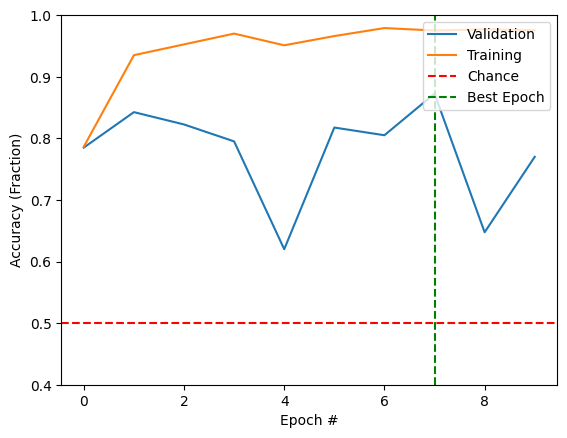

In [ ]:
#@title VGG19
#@
### YOUR CODE HERE
x_train, y_train = get_train_data()
x_test, y_test = get_test_data()
transfer = TransferClassifier(name = 'VGG19')
transfer.fit(x_train, y_train, epochs = 10, validation_data = (x_test, y_test), shuffle = True, callbacks = [monitor])
plot_acc(transfer.history)
### END CODE

**DENSENET121**

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5


 1/63 [..............................] - ETA: 22:41 - loss: 0.9300 - accuracy: 0.3438

 2/63 [..............................] - ETA: 3s - loss: 0.8922 - accuracy: 0.4375   

 3/63 [>.............................] - ETA: 3s - loss: 0.8248 - accuracy: 0.5000

 4/63 [>.............................] - ETA: 3s - loss: 0.8458 - accuracy: 0.4766

 5/63 [=>............................] - ETA: 4s - loss: 0.8249 - accuracy: 0.4938

 6/63 [=>............................] - ETA: 4s - loss: 0.8212 - accuracy: 0.5052

 7/63 [==>...........................] - ETA: 4s - loss: 0.8279 - accuracy: 0.5045

 8/63 [==>...........................] - ETA: 4s - loss: 0.8126 - accuracy: 0.5195

 9/63 [===>..........................] - ETA: 4s - loss: 0.8195 - accuracy: 0.5139

10/63 [===>..........................] - ETA: 4s - loss: 0.8138 - accuracy: 0.5156

11/63 [====>.........................] - ETA: 4s - loss: 0.8164 - accuracy: 0.5142

12/63 [====>.........................] - ETA: 4s - loss: 0.8011 - accuracy: 0.5208

13/63 [=====>........................] - ETA: 4s - loss: 0.7997 - accuracy: 0.5192

14/63 [=====>........................] - ETA: 4s - loss: 0.8039 - accuracy: 0.5179

15/63 [======>.......................] - ETA: 4s - loss: 0.8056 - accuracy: 0.5125

16/63 [======>.......................] - ETA: 4s - loss: 0.7982 - accuracy: 0.5176

17/63 [=======>......................] - ETA: 4s - loss: 0.8028 - accuracy: 0.5110

18/63 [=======>......................] - ETA: 3s - loss: 0.7990 - accuracy: 0.5139

19/63 [========>.....................] - ETA: 3s - loss: 0.7939 - accuracy: 0.5148

20/63 [========>.....................] - ETA: 3s - loss: 0.7922 - accuracy: 0.5172

21/63 [=========>....................] - ETA: 3s - loss: 0.8020 - accuracy: 0.5119

22/63 [=========>....................] - ETA: 3s - loss: 0.7945 - accuracy: 0.5170

23/63 [=========>....................] - ETA: 3s - loss: 0.7887 - accuracy: 0.5204

24/63 [==========>...................] - ETA: 3s - loss: 0.7885 - accuracy: 0.5208

25/63 [==========>...................] - ETA: 3s - loss: 0.7788 - accuracy: 0.5300

26/63 [===========>..................] - ETA: 3s - loss: 0.7728 - accuracy: 0.5361

27/63 [===========>..................] - ETA: 2s - loss: 0.7713 - accuracy: 0.5347

28/63 [============>.................] - ETA: 2s - loss: 0.7637 - accuracy: 0.5413

29/63 [============>.................] - ETA: 2s - loss: 0.7578 - accuracy: 0.5474

30/63 [=============>................] - ETA: 2s - loss: 0.7519 - accuracy: 0.5510

31/63 [=============>................] - ETA: 2s - loss: 0.7486 - accuracy: 0.5565

32/63 [==============>...............] - ETA: 2s - loss: 0.7504 - accuracy: 0.5557

33/63 [==============>...............] - ETA: 2s - loss: 0.7483 - accuracy: 0.5568

34/63 [===============>..............] - ETA: 2s - loss: 0.7484 - accuracy: 0.5542

35/63 [===============>..............] - ETA: 2s - loss: 0.7449 - accuracy: 0.5580

36/63 [================>.............] - ETA: 2s - loss: 0.7377 - accuracy: 0.5634

37/63 [================>.............] - ETA: 2s - loss: 0.7327 - accuracy: 0.5659

38/63 [=================>............] - ETA: 2s - loss: 0.7267 - accuracy: 0.5707

39/63 [=================>............] - ETA: 2s - loss: 0.7219 - accuracy: 0.5745

40/63 [==================>...........] - ETA: 2s - loss: 0.7174 - accuracy: 0.5789

41/63 [==================>...........] - ETA: 2s - loss: 0.7142 - accuracy: 0.5793

42/63 [===================>..........] - ETA: 2s - loss: 0.7082 - accuracy: 0.5841

43/63 [===================>..........] - ETA: 2s - loss: 0.7036 - accuracy: 0.5872

44/63 [===================>..........] - ETA: 2s - loss: 0.6984 - accuracy: 0.5916

45/63 [====================>.........] - ETA: 2s - loss: 0.6929 - accuracy: 0.5979

46/63 [====================>.........] - ETA: 2s - loss: 0.6841 - accuracy: 0.6039

47/63 [=====================>........] - ETA: 1s - loss: 0.6803 - accuracy: 0.6051

48/63 [=====================>........] - ETA: 1s - loss: 0.6767 - accuracy: 0.6068

49/63 [======================>.......] - ETA: 1s - loss: 0.6723 - accuracy: 0.6116

50/63 [======================>.......] - ETA: 1s - loss: 0.6679 - accuracy: 0.6150

51/63 [=======================>......] - ETA: 1s - loss: 0.6643 - accuracy: 0.6176

52/63 [=======================>......] - ETA: 1s - loss: 0.6615 - accuracy: 0.6190

53/63 [========================>.....] - ETA: 1s - loss: 0.6564 - accuracy: 0.6232

54/63 [========================>.....] - ETA: 1s - loss: 0.6519 - accuracy: 0.6262

55/63 [=========================>....] - ETA: 0s - loss: 0.6472 - accuracy: 0.6301

56/63 [=========================>....] - ETA: 0s - loss: 0.6424 - accuracy: 0.6339

57/63 [==========================>...] - ETA: 0s - loss: 0.6378 - accuracy: 0.6382

58/63 [==========================>...] - ETA: 0s - loss: 0.6342 - accuracy: 0.6406

59/63 [===========================>..] - ETA: 0s - loss: 0.6325 - accuracy: 0.6414

60/63 [===========================>..] - ETA: 0s - loss: 0.6304 - accuracy: 0.6422

61/63 [============================>.] - ETA: 0s - loss: 0.6275 - accuracy: 0.6445

62/63 [============================>.] - ETA: 0s - loss: 0.6272 - accuracy: 0.6452

63/63 [==============================] - 34s 202ms/step - loss: 0.6247 - accuracy: 0.6475 - val_loss: 0.6580 - val_accuracy: 0.6325
Epoch 2/5


 1/63 [..............................] - ETA: 6s - loss: 0.3366 - accuracy: 0.8125

 2/63 [..............................] - ETA: 5s - loss: 0.3379 - accuracy: 0.8438

 3/63 [>.............................] - ETA: 5s - loss: 0.3362 - accuracy: 0.8542

 4/63 [>.............................] - ETA: 5s - loss: 0.3480 - accuracy: 0.8359

 5/63 [=>............................] - ETA: 5s - loss: 0.3405 - accuracy: 0.8500

 6/63 [=>............................] - ETA: 5s - loss: 0.3595 - accuracy: 0.8490

 7/63 [==>...........................] - ETA: 5s - loss: 0.3536 - accuracy: 0.8482

 8/63 [==>...........................] - ETA: 4s - loss: 0.3792 - accuracy: 0.8281

 9/63 [===>..........................] - ETA: 4s - loss: 0.3682 - accuracy: 0.8299

10/63 [===>..........................] - ETA: 4s - loss: 0.3586 - accuracy: 0.8375

11/63 [====>.........................] - ETA: 3s - loss: 0.3632 - accuracy: 0.8352

12/63 [====>.........................] - ETA: 3s - loss: 0.3738 - accuracy: 0.8307

13/63 [=====>........................] - ETA: 3s - loss: 0.3705 - accuracy: 0.8341

14/63 [=====>........................] - ETA: 3s - loss: 0.3734 - accuracy: 0.8326

15/63 [======>.......................] - ETA: 3s - loss: 0.3713 - accuracy: 0.8375

16/63 [======>.......................] - ETA: 3s - loss: 0.3620 - accuracy: 0.8438

17/63 [=======>......................] - ETA: 3s - loss: 0.3594 - accuracy: 0.8438

18/63 [=======>......................] - ETA: 3s - loss: 0.3598 - accuracy: 0.8438

19/63 [========>.....................] - ETA: 2s - loss: 0.3568 - accuracy: 0.8470

20/63 [========>.....................] - ETA: 2s - loss: 0.3506 - accuracy: 0.8531

21/63 [=========>....................] - ETA: 2s - loss: 0.3467 - accuracy: 0.8542

22/63 [=========>....................] - ETA: 2s - loss: 0.3455 - accuracy: 0.8565

23/63 [=========>....................] - ETA: 2s - loss: 0.3404 - accuracy: 0.8614

24/63 [==========>...................] - ETA: 2s - loss: 0.3379 - accuracy: 0.8633

25/63 [==========>...................] - ETA: 2s - loss: 0.3323 - accuracy: 0.8662

26/63 [===========>..................] - ETA: 2s - loss: 0.3310 - accuracy: 0.8678

27/63 [===========>..................] - ETA: 2s - loss: 0.3295 - accuracy: 0.8692

28/63 [============>.................] - ETA: 2s - loss: 0.3303 - accuracy: 0.8705

29/63 [============>.................] - ETA: 2s - loss: 0.3292 - accuracy: 0.8718

30/63 [=============>................] - ETA: 2s - loss: 0.3263 - accuracy: 0.8740

31/63 [=============>................] - ETA: 1s - loss: 0.3295 - accuracy: 0.8720

32/63 [==============>...............] - ETA: 1s - loss: 0.3297 - accuracy: 0.8721

33/63 [==============>...............] - ETA: 1s - loss: 0.3285 - accuracy: 0.8722

34/63 [===============>..............] - ETA: 1s - loss: 0.3255 - accuracy: 0.8750

35/63 [===============>..............] - ETA: 1s - loss: 0.3246 - accuracy: 0.8759

36/63 [================>.............] - ETA: 1s - loss: 0.3215 - accuracy: 0.8776

37/63 [================>.............] - ETA: 1s - loss: 0.3178 - accuracy: 0.8801

38/63 [=================>............] - ETA: 1s - loss: 0.3179 - accuracy: 0.8799

39/63 [=================>............] - ETA: 1s - loss: 0.3167 - accuracy: 0.8798

40/63 [==================>...........] - ETA: 1s - loss: 0.3148 - accuracy: 0.8797

41/63 [==================>...........] - ETA: 1s - loss: 0.3128 - accuracy: 0.8803

42/63 [===================>..........] - ETA: 1s - loss: 0.3109 - accuracy: 0.8810

43/63 [===================>..........] - ETA: 1s - loss: 0.3087 - accuracy: 0.8823

44/63 [===================>..........] - ETA: 1s - loss: 0.3076 - accuracy: 0.8821

45/63 [====================>.........] - ETA: 1s - loss: 0.3057 - accuracy: 0.8833

46/63 [====================>.........] - ETA: 1s - loss: 0.3035 - accuracy: 0.8852

47/63 [=====================>........] - ETA: 0s - loss: 0.3037 - accuracy: 0.8843

48/63 [=====================>........] - ETA: 0s - loss: 0.3018 - accuracy: 0.8841

49/63 [======================>.......] - ETA: 0s - loss: 0.2999 - accuracy: 0.8846

50/63 [======================>.......] - ETA: 0s - loss: 0.3012 - accuracy: 0.8831

51/63 [=======================>......] - ETA: 0s - loss: 0.2985 - accuracy: 0.8848

52/63 [=======================>......] - ETA: 0s - loss: 0.3010 - accuracy: 0.8846

53/63 [========================>.....] - ETA: 0s - loss: 0.2993 - accuracy: 0.8850

54/63 [========================>.....] - ETA: 0s - loss: 0.2996 - accuracy: 0.8843

55/63 [=========================>....] - ETA: 0s - loss: 0.2986 - accuracy: 0.8852

56/63 [=========================>....] - ETA: 0s - loss: 0.2992 - accuracy: 0.8850

57/63 [==========================>...] - ETA: 0s - loss: 0.2984 - accuracy: 0.8854

58/63 [==========================>...] - ETA: 0s - loss: 0.2965 - accuracy: 0.8858

59/63 [===========================>..] - ETA: 0s - loss: 0.2963 - accuracy: 0.8851

60/63 [===========================>..] - ETA: 0s - loss: 0.2969 - accuracy: 0.8839

61/63 [============================>.] - ETA: 0s - loss: 0.2952 - accuracy: 0.8852

62/63 [============================>.] - ETA: 0s - loss: 0.2948 - accuracy: 0.8861

63/63 [==============================] - 4s 69ms/step - loss: 0.2948 - accuracy: 0.8865 - val_loss: 0.5891 - val_accuracy: 0.6775
Epoch 3/5


 1/63 [..............................] - ETA: 4s - loss: 0.1499 - accuracy: 0.9688

 2/63 [..............................] - ETA: 4s - loss: 0.1719 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 4s - loss: 0.1924 - accuracy: 0.9583

 4/63 [>.............................] - ETA: 4s - loss: 0.2172 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 4s - loss: 0.2327 - accuracy: 0.9312

 6/63 [=>............................] - ETA: 4s - loss: 0.2152 - accuracy: 0.9427

 7/63 [==>...........................] - ETA: 4s - loss: 0.2274 - accuracy: 0.9286

 8/63 [==>...........................] - ETA: 4s - loss: 0.2166 - accuracy: 0.9297

 9/63 [===>..........................] - ETA: 4s - loss: 0.2131 - accuracy: 0.9271

10/63 [===>..........................] - ETA: 4s - loss: 0.2042 - accuracy: 0.9312

11/63 [====>.........................] - ETA: 3s - loss: 0.2009 - accuracy: 0.9347

12/63 [====>.........................] - ETA: 3s - loss: 0.1953 - accuracy: 0.9375

13/63 [=====>........................] - ETA: 3s - loss: 0.1982 - accuracy: 0.9375

14/63 [=====>........................] - ETA: 3s - loss: 0.1933 - accuracy: 0.9397

15/63 [======>.......................] - ETA: 3s - loss: 0.1952 - accuracy: 0.9417

16/63 [======>.......................] - ETA: 3s - loss: 0.1921 - accuracy: 0.9453

17/63 [=======>......................] - ETA: 3s - loss: 0.1855 - accuracy: 0.9485

18/63 [=======>......................] - ETA: 3s - loss: 0.1845 - accuracy: 0.9497

19/63 [========>.....................] - ETA: 3s - loss: 0.1856 - accuracy: 0.9474

20/63 [========>.....................] - ETA: 2s - loss: 0.1847 - accuracy: 0.9469

21/63 [=========>....................] - ETA: 2s - loss: 0.1792 - accuracy: 0.9494

22/63 [=========>....................] - ETA: 2s - loss: 0.1808 - accuracy: 0.9474

23/63 [=========>....................] - ETA: 2s - loss: 0.1812 - accuracy: 0.9470

24/63 [==========>...................] - ETA: 2s - loss: 0.1832 - accuracy: 0.9453

25/63 [==========>...................] - ETA: 2s - loss: 0.1819 - accuracy: 0.9463

26/63 [===========>..................] - ETA: 2s - loss: 0.1845 - accuracy: 0.9459

27/63 [===========>..................] - ETA: 2s - loss: 0.1822 - accuracy: 0.9479

28/63 [============>.................] - ETA: 2s - loss: 0.1808 - accuracy: 0.9487

29/63 [============>.................] - ETA: 2s - loss: 0.1794 - accuracy: 0.9494

30/63 [=============>................] - ETA: 2s - loss: 0.1807 - accuracy: 0.9469

31/63 [=============>................] - ETA: 2s - loss: 0.1808 - accuracy: 0.9456

32/63 [==============>...............] - ETA: 2s - loss: 0.1818 - accuracy: 0.9453

33/63 [==============>...............] - ETA: 1s - loss: 0.1797 - accuracy: 0.9451

34/63 [===============>..............] - ETA: 1s - loss: 0.1801 - accuracy: 0.9449

35/63 [===============>..............] - ETA: 1s - loss: 0.1789 - accuracy: 0.9455

36/63 [================>.............] - ETA: 1s - loss: 0.1777 - accuracy: 0.9462

37/63 [================>.............] - ETA: 1s - loss: 0.1783 - accuracy: 0.9459

38/63 [=================>............] - ETA: 1s - loss: 0.1776 - accuracy: 0.9457

39/63 [=================>............] - ETA: 1s - loss: 0.1771 - accuracy: 0.9455

40/63 [==================>...........] - ETA: 1s - loss: 0.1762 - accuracy: 0.9461

41/63 [==================>...........] - ETA: 1s - loss: 0.1750 - accuracy: 0.9466

42/63 [===================>..........] - ETA: 1s - loss: 0.1752 - accuracy: 0.9457

43/63 [===================>..........] - ETA: 1s - loss: 0.1757 - accuracy: 0.9462

44/63 [===================>..........] - ETA: 1s - loss: 0.1758 - accuracy: 0.9460

45/63 [====================>.........] - ETA: 1s - loss: 0.1752 - accuracy: 0.9458

46/63 [====================>.........] - ETA: 1s - loss: 0.1754 - accuracy: 0.9457

47/63 [=====================>........] - ETA: 1s - loss: 0.1755 - accuracy: 0.9455

48/63 [=====================>........] - ETA: 0s - loss: 0.1736 - accuracy: 0.9460

49/63 [======================>.......] - ETA: 0s - loss: 0.1735 - accuracy: 0.9452

50/63 [======================>.......] - ETA: 0s - loss: 0.1728 - accuracy: 0.9450

51/63 [=======================>......] - ETA: 0s - loss: 0.1717 - accuracy: 0.9461

52/63 [=======================>......] - ETA: 0s - loss: 0.1716 - accuracy: 0.9453

53/63 [========================>.....] - ETA: 0s - loss: 0.1716 - accuracy: 0.9452

54/63 [========================>.....] - ETA: 0s - loss: 0.1731 - accuracy: 0.9444

55/63 [=========================>....] - ETA: 0s - loss: 0.1724 - accuracy: 0.9443

56/63 [=========================>....] - ETA: 0s - loss: 0.1720 - accuracy: 0.9442

57/63 [==========================>...] - ETA: 0s - loss: 0.1723 - accuracy: 0.9435

58/63 [==========================>...] - ETA: 0s - loss: 0.1725 - accuracy: 0.9434

59/63 [===========================>..] - ETA: 0s - loss: 0.1716 - accuracy: 0.9439

60/63 [===========================>..] - ETA: 0s - loss: 0.1708 - accuracy: 0.9448

61/63 [============================>.] - ETA: 0s - loss: 0.1699 - accuracy: 0.9452

62/63 [============================>.] - ETA: 0s - loss: 0.1705 - accuracy: 0.9451

63/63 [==============================] - 4s 66ms/step - loss: 0.1703 - accuracy: 0.9450 - val_loss: 0.5896 - val_accuracy: 0.7325
Epoch 4/5


 1/63 [..............................] - ETA: 4s - loss: 0.0821 - accuracy: 1.0000

 2/63 [..............................] - ETA: 3s - loss: 0.0929 - accuracy: 0.9844

 3/63 [>.............................] - ETA: 3s - loss: 0.1038 - accuracy: 0.9792

 4/63 [>.............................] - ETA: 3s - loss: 0.1019 - accuracy: 0.9766

 5/63 [=>............................] - ETA: 3s - loss: 0.1235 - accuracy: 0.9625

 6/63 [=>............................] - ETA: 3s - loss: 0.1221 - accuracy: 0.9635

 7/63 [==>...........................] - ETA: 3s - loss: 0.1504 - accuracy: 0.9509

 8/63 [==>...........................] - ETA: 3s - loss: 0.1423 - accuracy: 0.9531

 9/63 [===>..........................] - ETA: 3s - loss: 0.1400 - accuracy: 0.9514

10/63 [===>..........................] - ETA: 3s - loss: 0.1342 - accuracy: 0.9500

11/63 [====>.........................] - ETA: 2s - loss: 0.1296 - accuracy: 0.9545

12/63 [====>.........................] - ETA: 2s - loss: 0.1261 - accuracy: 0.9583

13/63 [=====>........................] - ETA: 2s - loss: 0.1257 - accuracy: 0.9591

14/63 [=====>........................] - ETA: 2s - loss: 0.1243 - accuracy: 0.9598

15/63 [======>.......................] - ETA: 2s - loss: 0.1211 - accuracy: 0.9625

16/63 [======>.......................] - ETA: 2s - loss: 0.1203 - accuracy: 0.9609

17/63 [=======>......................] - ETA: 2s - loss: 0.1199 - accuracy: 0.9614

18/63 [=======>......................] - ETA: 2s - loss: 0.1242 - accuracy: 0.9549

19/63 [========>.....................] - ETA: 2s - loss: 0.1259 - accuracy: 0.9556

20/63 [========>.....................] - ETA: 2s - loss: 0.1367 - accuracy: 0.9484

21/63 [=========>....................] - ETA: 2s - loss: 0.1343 - accuracy: 0.9494

22/63 [=========>....................] - ETA: 2s - loss: 0.1327 - accuracy: 0.9517

23/63 [=========>....................] - ETA: 2s - loss: 0.1329 - accuracy: 0.9511

24/63 [==========>...................] - ETA: 2s - loss: 0.1420 - accuracy: 0.9466

25/63 [==========>...................] - ETA: 2s - loss: 0.1416 - accuracy: 0.9463

26/63 [===========>..................] - ETA: 2s - loss: 0.1435 - accuracy: 0.9447

27/63 [===========>..................] - ETA: 2s - loss: 0.1407 - accuracy: 0.9468

28/63 [============>.................] - ETA: 2s - loss: 0.1381 - accuracy: 0.9487

29/63 [============>.................] - ETA: 1s - loss: 0.1377 - accuracy: 0.9483

30/63 [=============>................] - ETA: 1s - loss: 0.1375 - accuracy: 0.9490

31/63 [=============>................] - ETA: 1s - loss: 0.1388 - accuracy: 0.9486

32/63 [==============>...............] - ETA: 1s - loss: 0.1364 - accuracy: 0.9502

33/63 [==============>...............] - ETA: 1s - loss: 0.1356 - accuracy: 0.9508

34/63 [===============>..............] - ETA: 1s - loss: 0.1336 - accuracy: 0.9522

35/63 [===============>..............] - ETA: 1s - loss: 0.1323 - accuracy: 0.9536

36/63 [================>.............] - ETA: 1s - loss: 0.1313 - accuracy: 0.9540

37/63 [================>.............] - ETA: 1s - loss: 0.1334 - accuracy: 0.9535

38/63 [=================>............] - ETA: 1s - loss: 0.1332 - accuracy: 0.9539

39/63 [=================>............] - ETA: 1s - loss: 0.1317 - accuracy: 0.9543

40/63 [==================>...........] - ETA: 1s - loss: 0.1326 - accuracy: 0.9523

41/63 [==================>...........] - ETA: 1s - loss: 0.1319 - accuracy: 0.9527

42/63 [===================>..........] - ETA: 1s - loss: 0.1323 - accuracy: 0.9524

43/63 [===================>..........] - ETA: 1s - loss: 0.1313 - accuracy: 0.9520

44/63 [===================>..........] - ETA: 1s - loss: 0.1300 - accuracy: 0.9531

45/63 [====================>.........] - ETA: 1s - loss: 0.1291 - accuracy: 0.9535

46/63 [====================>.........] - ETA: 0s - loss: 0.1328 - accuracy: 0.9524

47/63 [=====================>........] - ETA: 0s - loss: 0.1333 - accuracy: 0.9528

48/63 [=====================>........] - ETA: 0s - loss: 0.1330 - accuracy: 0.9531

49/63 [======================>.......] - ETA: 0s - loss: 0.1329 - accuracy: 0.9522

50/63 [======================>.......] - ETA: 0s - loss: 0.1345 - accuracy: 0.9506

51/63 [=======================>......] - ETA: 0s - loss: 0.1355 - accuracy: 0.9498

52/63 [=======================>......] - ETA: 0s - loss: 0.1376 - accuracy: 0.9489

53/63 [========================>.....] - ETA: 0s - loss: 0.1365 - accuracy: 0.9499

54/63 [========================>.....] - ETA: 0s - loss: 0.1362 - accuracy: 0.9502

55/63 [=========================>....] - ETA: 0s - loss: 0.1379 - accuracy: 0.9500

56/63 [=========================>....] - ETA: 0s - loss: 0.1375 - accuracy: 0.9498

57/63 [==========================>...] - ETA: 0s - loss: 0.1396 - accuracy: 0.9490

58/63 [==========================>...] - ETA: 0s - loss: 0.1389 - accuracy: 0.9494

59/63 [===========================>..] - ETA: 0s - loss: 0.1382 - accuracy: 0.9497

60/63 [===========================>..] - ETA: 0s - loss: 0.1375 - accuracy: 0.9500

61/63 [============================>.] - ETA: 0s - loss: 0.1378 - accuracy: 0.9503

62/63 [============================>.] - ETA: 0s - loss: 0.1366 - accuracy: 0.9511

63/63 [==============================] - 4s 62ms/step - loss: 0.1356 - accuracy: 0.9515 - val_loss: 0.6329 - val_accuracy: 0.7125
Epoch 5/5


 1/63 [..............................] - ETA: 3s - loss: 0.0827 - accuracy: 0.9688

 2/63 [..............................] - ETA: 3s - loss: 0.1069 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 3s - loss: 0.0988 - accuracy: 0.9792

 4/63 [>.............................] - ETA: 3s - loss: 0.0880 - accuracy: 0.9844

 5/63 [=>............................] - ETA: 3s - loss: 0.0864 - accuracy: 0.9812

 6/63 [=>............................] - ETA: 3s - loss: 0.0843 - accuracy: 0.9844

 7/63 [==>...........................] - ETA: 3s - loss: 0.0852 - accuracy: 0.9821

 8/63 [==>...........................] - ETA: 3s - loss: 0.0816 - accuracy: 0.9844

 9/63 [===>..........................] - ETA: 3s - loss: 0.0809 - accuracy: 0.9861

10/63 [===>..........................] - ETA: 3s - loss: 0.0797 - accuracy: 0.9875

11/63 [====>.........................] - ETA: 3s - loss: 0.0810 - accuracy: 0.9858

12/63 [====>.........................] - ETA: 3s - loss: 0.0823 - accuracy: 0.9818

13/63 [=====>........................] - ETA: 2s - loss: 0.0862 - accuracy: 0.9808

14/63 [=====>........................] - ETA: 2s - loss: 0.0831 - accuracy: 0.9821

15/63 [======>.......................] - ETA: 2s - loss: 0.0823 - accuracy: 0.9833

16/63 [======>.......................] - ETA: 2s - loss: 0.0882 - accuracy: 0.9805

17/63 [=======>......................] - ETA: 2s - loss: 0.0922 - accuracy: 0.9779

18/63 [=======>......................] - ETA: 2s - loss: 0.0896 - accuracy: 0.9792

19/63 [========>.....................] - ETA: 2s - loss: 0.0948 - accuracy: 0.9770

20/63 [========>.....................] - ETA: 2s - loss: 0.0934 - accuracy: 0.9781

21/63 [=========>....................] - ETA: 2s - loss: 0.0958 - accuracy: 0.9762

22/63 [=========>....................] - ETA: 2s - loss: 0.0932 - accuracy: 0.9773

23/63 [=========>....................] - ETA: 2s - loss: 0.0932 - accuracy: 0.9769

24/63 [==========>...................] - ETA: 2s - loss: 0.0935 - accuracy: 0.9779

25/63 [==========>...................] - ETA: 2s - loss: 0.0922 - accuracy: 0.9787

26/63 [===========>..................] - ETA: 2s - loss: 0.0931 - accuracy: 0.9784

27/63 [===========>..................] - ETA: 2s - loss: 0.0941 - accuracy: 0.9780

28/63 [============>.................] - ETA: 2s - loss: 0.0931 - accuracy: 0.9777

29/63 [============>.................] - ETA: 2s - loss: 0.0923 - accuracy: 0.9784

30/63 [=============>................] - ETA: 1s - loss: 0.0907 - accuracy: 0.9792

31/63 [=============>................] - ETA: 1s - loss: 0.0938 - accuracy: 0.9768

32/63 [==============>...............] - ETA: 1s - loss: 0.0928 - accuracy: 0.9775

33/63 [==============>...............] - ETA: 1s - loss: 0.0914 - accuracy: 0.9782

34/63 [===============>..............] - ETA: 1s - loss: 0.0923 - accuracy: 0.9770

35/63 [===============>..............] - ETA: 1s - loss: 0.0911 - accuracy: 0.9777

36/63 [================>.............] - ETA: 1s - loss: 0.0905 - accuracy: 0.9774

37/63 [================>.............] - ETA: 1s - loss: 0.0889 - accuracy: 0.9780

38/63 [=================>............] - ETA: 1s - loss: 0.0901 - accuracy: 0.9770

39/63 [=================>............] - ETA: 1s - loss: 0.0905 - accuracy: 0.9768

40/63 [==================>...........] - ETA: 1s - loss: 0.0903 - accuracy: 0.9766

41/63 [==================>...........] - ETA: 1s - loss: 0.0891 - accuracy: 0.9771

42/63 [===================>..........] - ETA: 1s - loss: 0.0885 - accuracy: 0.9777

43/63 [===================>..........] - ETA: 1s - loss: 0.0881 - accuracy: 0.9775

44/63 [===================>..........] - ETA: 1s - loss: 0.0878 - accuracy: 0.9773

45/63 [====================>.........] - ETA: 1s - loss: 0.0867 - accuracy: 0.9778

46/63 [====================>.........] - ETA: 1s - loss: 0.0884 - accuracy: 0.9769

47/63 [=====================>........] - ETA: 0s - loss: 0.0921 - accuracy: 0.9761

48/63 [=====================>........] - ETA: 0s - loss: 0.0925 - accuracy: 0.9759

49/63 [======================>.......] - ETA: 0s - loss: 0.0920 - accuracy: 0.9764

50/63 [======================>.......] - ETA: 0s - loss: 0.0912 - accuracy: 0.9769

51/63 [=======================>......] - ETA: 0s - loss: 0.0919 - accuracy: 0.9761

52/63 [=======================>......] - ETA: 0s - loss: 0.0913 - accuracy: 0.9766

53/63 [========================>.....] - ETA: 0s - loss: 0.0914 - accuracy: 0.9764

54/63 [========================>.....] - ETA: 0s - loss: 0.0911 - accuracy: 0.9763

55/63 [=========================>....] - ETA: 0s - loss: 0.0923 - accuracy: 0.9750

56/63 [=========================>....] - ETA: 0s - loss: 0.0936 - accuracy: 0.9743

57/63 [==========================>...] - ETA: 0s - loss: 0.0935 - accuracy: 0.9748

58/63 [==========================>...] - ETA: 0s - loss: 0.0951 - accuracy: 0.9741

59/63 [===========================>..] - ETA: 0s - loss: 0.0953 - accuracy: 0.9735

60/63 [===========================>..] - ETA: 0s - loss: 0.0953 - accuracy: 0.9729

61/63 [============================>.] - ETA: 0s - loss: 0.0967 - accuracy: 0.9718

62/63 [============================>.] - ETA: 0s - loss: 0.0965 - accuracy: 0.9718

63/63 [==============================] - 4s 68ms/step - loss: 0.0960 - accuracy: 0.9720 - val_loss: 0.5838 - val_accuracy: 0.7550


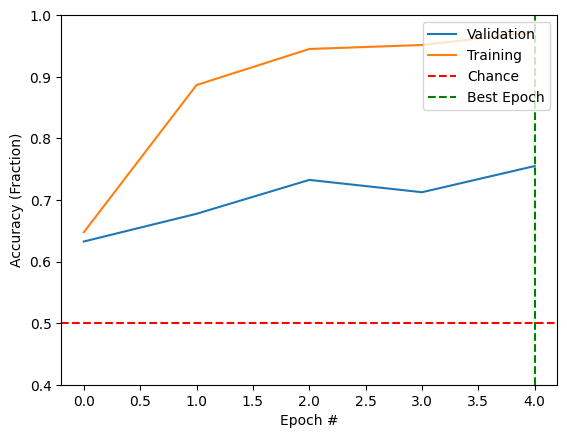

In [ ]:
transfer1 = TransferClassifier(name = 'DenseNet121')
transfer1.fit(x_train, y_train, epochs = 5, validation_data = (x_test, y_test), shuffle = True, callbacks = [monitor])
plot_acc(transfer1.history)

**RESNET50**

94765736/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5


 1/63 [..............................] - ETA: 7:34 - loss: 0.6381 - accuracy: 0.5938

 2/63 [..............................] - ETA: 3s - loss: 0.6624 - accuracy: 0.6719  

 3/63 [>.............................] - ETA: 3s - loss: 0.6575 - accuracy: 0.6875

 4/63 [>.............................] - ETA: 3s - loss: 0.6550 - accuracy: 0.6641

 5/63 [=>............................] - ETA: 3s - loss: 0.6676 - accuracy: 0.6438

 6/63 [=>............................] - ETA: 2s - loss: 0.6702 - accuracy: 0.6458

 7/63 [==>...........................] - ETA: 2s - loss: 0.6765 - accuracy: 0.6339

 8/63 [==>...........................] - ETA: 2s - loss: 0.6732 - accuracy: 0.6328

 9/63 [===>..........................] - ETA: 2s - loss: 0.6842 - accuracy: 0.6354

10/63 [===>..........................] - ETA: 2s - loss: 0.6879 - accuracy: 0.6125

11/63 [====>.........................] - ETA: 2s - loss: 0.6838 - accuracy: 0.6193

13/63 [=====>........................] - ETA: 2s - loss: 0.6834 - accuracy: 0.6226

14/63 [=====>........................] - ETA: 2s - loss: 0.6913 - accuracy: 0.6183

15/63 [======>.......................] - ETA: 2s - loss: 0.6973 - accuracy: 0.6125

16/63 [======>.......................] - ETA: 2s - loss: 0.6938 - accuracy: 0.6152

17/63 [=======>......................] - ETA: 2s - loss: 0.6917 - accuracy: 0.6158

18/63 [=======>......................] - ETA: 2s - loss: 0.6908 - accuracy: 0.6181

19/63 [========>.....................] - ETA: 2s - loss: 0.6856 - accuracy: 0.6201

20/63 [========>.....................] - ETA: 2s - loss: 0.6859 - accuracy: 0.6187

21/63 [=========>....................] - ETA: 2s - loss: 0.6833 - accuracy: 0.6235

22/63 [=========>....................] - ETA: 2s - loss: 0.6758 - accuracy: 0.6321

23/63 [=========>....................] - ETA: 2s - loss: 0.6830 - accuracy: 0.6277

24/63 [==========>...................] - ETA: 2s - loss: 0.6837 - accuracy: 0.6250

25/63 [==========>...................] - ETA: 1s - loss: 0.6863 - accuracy: 0.6200

26/63 [===========>..................] - ETA: 1s - loss: 0.6869 - accuracy: 0.6166

27/63 [===========>..................] - ETA: 1s - loss: 0.6875 - accuracy: 0.6157

28/63 [============>.................] - ETA: 1s - loss: 0.6865 - accuracy: 0.6172

29/63 [============>.................] - ETA: 1s - loss: 0.6850 - accuracy: 0.6164

30/63 [=============>................] - ETA: 1s - loss: 0.6844 - accuracy: 0.6167

31/63 [=============>................] - ETA: 1s - loss: 0.6860 - accuracy: 0.6159

32/63 [==============>...............] - ETA: 1s - loss: 0.6827 - accuracy: 0.6182

33/63 [==============>...............] - ETA: 1s - loss: 0.6796 - accuracy: 0.6222

34/63 [===============>..............] - ETA: 1s - loss: 0.6829 - accuracy: 0.6167

35/63 [===============>..............] - ETA: 1s - loss: 0.6787 - accuracy: 0.6196

36/63 [================>.............] - ETA: 1s - loss: 0.6804 - accuracy: 0.6172

37/63 [================>.............] - ETA: 1s - loss: 0.6775 - accuracy: 0.6191

38/63 [=================>............] - ETA: 1s - loss: 0.6772 - accuracy: 0.6168

39/63 [=================>............] - ETA: 1s - loss: 0.6751 - accuracy: 0.6170

40/63 [==================>...........] - ETA: 1s - loss: 0.6718 - accuracy: 0.6195

41/63 [==================>...........] - ETA: 1s - loss: 0.6702 - accuracy: 0.6189

42/63 [===================>..........] - ETA: 1s - loss: 0.6674 - accuracy: 0.6220

43/63 [===================>..........] - ETA: 1s - loss: 0.6672 - accuracy: 0.6250

44/63 [===================>..........] - ETA: 1s - loss: 0.6638 - accuracy: 0.6286

45/63 [====================>.........] - ETA: 0s - loss: 0.6618 - accuracy: 0.6292

46/63 [====================>.........] - ETA: 0s - loss: 0.6600 - accuracy: 0.6311

47/63 [=====================>........] - ETA: 0s - loss: 0.6594 - accuracy: 0.6330

48/63 [=====================>........] - ETA: 0s - loss: 0.6595 - accuracy: 0.6309

49/63 [======================>.......] - ETA: 0s - loss: 0.6570 - accuracy: 0.6339

50/63 [======================>.......] - ETA: 0s - loss: 0.6547 - accuracy: 0.6350

51/63 [=======================>......] - ETA: 0s - loss: 0.6554 - accuracy: 0.6348

52/63 [=======================>......] - ETA: 0s - loss: 0.6551 - accuracy: 0.6340

53/63 [========================>.....] - ETA: 0s - loss: 0.6512 - accuracy: 0.6374

54/63 [========================>.....] - ETA: 0s - loss: 0.6487 - accuracy: 0.6400

55/63 [=========================>....] - ETA: 0s - loss: 0.6462 - accuracy: 0.6420

56/63 [=========================>....] - ETA: 0s - loss: 0.6440 - accuracy: 0.6445

57/63 [==========================>...] - ETA: 0s - loss: 0.6438 - accuracy: 0.6431

58/63 [==========================>...] - ETA: 0s - loss: 0.6413 - accuracy: 0.6460

59/63 [===========================>..] - ETA: 0s - loss: 0.6381 - accuracy: 0.6499

60/63 [===========================>..] - ETA: 0s - loss: 0.6352 - accuracy: 0.6536

61/63 [============================>.] - ETA: 0s - loss: 0.6320 - accuracy: 0.6583

62/63 [============================>.] - ETA: 0s - loss: 0.6306 - accuracy: 0.6583

63/63 [==============================] - 13s 94ms/step - loss: 0.6297 - accuracy: 0.6595 - val_loss: 2.3495 - val_accuracy: 0.5000
Epoch 2/5


 1/63 [..............................] - ETA: 3s - loss: 0.4817 - accuracy: 0.8438

 2/63 [..............................] - ETA: 3s - loss: 0.5188 - accuracy: 0.8125

 3/63 [>.............................] - ETA: 3s - loss: 0.4891 - accuracy: 0.8333

 4/63 [>.............................] - ETA: 3s - loss: 0.4748 - accuracy: 0.8438

 5/63 [=>............................] - ETA: 3s - loss: 0.4570 - accuracy: 0.8250

 6/63 [=>............................] - ETA: 3s - loss: 0.4465 - accuracy: 0.8333

 7/63 [==>...........................] - ETA: 2s - loss: 0.4372 - accuracy: 0.8393

 8/63 [==>...........................] - ETA: 2s - loss: 0.4350 - accuracy: 0.8320

 9/63 [===>..........................] - ETA: 2s - loss: 0.4339 - accuracy: 0.8333

10/63 [===>..........................] - ETA: 2s - loss: 0.4519 - accuracy: 0.8156

11/63 [====>.........................] - ETA: 2s - loss: 0.4531 - accuracy: 0.8125

12/63 [====>.........................] - ETA: 2s - loss: 0.4496 - accuracy: 0.8125

13/63 [=====>........................] - ETA: 2s - loss: 0.4516 - accuracy: 0.8149

14/63 [=====>........................] - ETA: 2s - loss: 0.4470 - accuracy: 0.8237

15/63 [======>.......................] - ETA: 2s - loss: 0.4516 - accuracy: 0.8188

16/63 [======>.......................] - ETA: 2s - loss: 0.4530 - accuracy: 0.8164

17/63 [=======>......................] - ETA: 2s - loss: 0.4473 - accuracy: 0.8235

18/63 [=======>......................] - ETA: 2s - loss: 0.4471 - accuracy: 0.8212

19/63 [========>.....................] - ETA: 2s - loss: 0.4509 - accuracy: 0.8174

20/63 [========>.....................] - ETA: 2s - loss: 0.4492 - accuracy: 0.8203

21/63 [=========>....................] - ETA: 2s - loss: 0.4507 - accuracy: 0.8199

22/63 [=========>....................] - ETA: 2s - loss: 0.4591 - accuracy: 0.8139

23/63 [=========>....................] - ETA: 2s - loss: 0.4553 - accuracy: 0.8166

24/63 [==========>...................] - ETA: 2s - loss: 0.4509 - accuracy: 0.8177

25/63 [==========>...................] - ETA: 2s - loss: 0.4514 - accuracy: 0.8163

26/63 [===========>..................] - ETA: 1s - loss: 0.4506 - accuracy: 0.8185

27/63 [===========>..................] - ETA: 1s - loss: 0.4511 - accuracy: 0.8194

28/63 [============>.................] - ETA: 1s - loss: 0.4465 - accuracy: 0.8237

29/63 [============>.................] - ETA: 1s - loss: 0.4460 - accuracy: 0.8222

30/63 [=============>................] - ETA: 1s - loss: 0.4479 - accuracy: 0.8208

31/63 [=============>................] - ETA: 1s - loss: 0.4513 - accuracy: 0.8165

32/63 [==============>...............] - ETA: 1s - loss: 0.4460 - accuracy: 0.8203

33/63 [==============>...............] - ETA: 1s - loss: 0.4449 - accuracy: 0.8210

34/63 [===============>..............] - ETA: 1s - loss: 0.4411 - accuracy: 0.8254

35/63 [===============>..............] - ETA: 1s - loss: 0.4437 - accuracy: 0.8250

36/63 [================>.............] - ETA: 1s - loss: 0.4417 - accuracy: 0.8273

37/63 [================>.............] - ETA: 1s - loss: 0.4398 - accuracy: 0.8277

38/63 [=================>............] - ETA: 1s - loss: 0.4382 - accuracy: 0.8289

39/63 [=================>............] - ETA: 1s - loss: 0.4356 - accuracy: 0.8293

40/63 [==================>...........] - ETA: 1s - loss: 0.4330 - accuracy: 0.8297

41/63 [==================>...........] - ETA: 1s - loss: 0.4316 - accuracy: 0.8293

42/63 [===================>..........] - ETA: 1s - loss: 0.4308 - accuracy: 0.8281

43/63 [===================>..........] - ETA: 1s - loss: 0.4295 - accuracy: 0.8292

44/63 [===================>..........] - ETA: 1s - loss: 0.4266 - accuracy: 0.8317

45/63 [====================>.........] - ETA: 0s - loss: 0.4247 - accuracy: 0.8333

46/63 [====================>.........] - ETA: 0s - loss: 0.4231 - accuracy: 0.8349

47/63 [=====================>........] - ETA: 0s - loss: 0.4238 - accuracy: 0.8331

48/63 [=====================>........] - ETA: 0s - loss: 0.4210 - accuracy: 0.8346

49/63 [======================>.......] - ETA: 0s - loss: 0.4195 - accuracy: 0.8348

50/63 [======================>.......] - ETA: 0s - loss: 0.4196 - accuracy: 0.8338

51/63 [=======================>......] - ETA: 0s - loss: 0.4187 - accuracy: 0.8346

52/63 [=======================>......] - ETA: 0s - loss: 0.4170 - accuracy: 0.8359

53/63 [========================>.....] - ETA: 0s - loss: 0.4159 - accuracy: 0.8367

54/63 [========================>.....] - ETA: 0s - loss: 0.4140 - accuracy: 0.8374

55/63 [=========================>....] - ETA: 0s - loss: 0.4133 - accuracy: 0.8375

56/63 [=========================>....] - ETA: 0s - loss: 0.4118 - accuracy: 0.8382

57/63 [==========================>...] - ETA: 0s - loss: 0.4094 - accuracy: 0.8399

58/63 [==========================>...] - ETA: 0s - loss: 0.4077 - accuracy: 0.8405

59/63 [===========================>..] - ETA: 0s - loss: 0.4059 - accuracy: 0.8416

60/63 [===========================>..] - ETA: 0s - loss: 0.4036 - accuracy: 0.8427

61/63 [============================>.] - ETA: 0s - loss: 0.4030 - accuracy: 0.8438

62/63 [============================>.] - ETA: 0s - loss: 0.4030 - accuracy: 0.8427

63/63 [==============================] - 4s 58ms/step - loss: 0.4020 - accuracy: 0.8435 - val_loss: 8.2350 - val_accuracy: 0.5000
Epoch 3/5


 1/63 [..............................] - ETA: 3s - loss: 0.3630 - accuracy: 0.8438

 2/63 [..............................] - ETA: 3s - loss: 0.3260 - accuracy: 0.8594

 3/63 [>.............................] - ETA: 3s - loss: 0.3336 - accuracy: 0.8750

 4/63 [>.............................] - ETA: 3s - loss: 0.3189 - accuracy: 0.8750

 5/63 [=>............................] - ETA: 3s - loss: 0.3375 - accuracy: 0.8438

 6/63 [=>............................] - ETA: 3s - loss: 0.3413 - accuracy: 0.8490

 7/63 [==>...........................] - ETA: 3s - loss: 0.3315 - accuracy: 0.8571

 8/63 [==>...........................] - ETA: 3s - loss: 0.3352 - accuracy: 0.8555

 9/63 [===>..........................] - ETA: 3s - loss: 0.3319 - accuracy: 0.8576

10/63 [===>..........................] - ETA: 3s - loss: 0.3326 - accuracy: 0.8562

11/63 [====>.........................] - ETA: 2s - loss: 0.3339 - accuracy: 0.8580

12/63 [====>.........................] - ETA: 2s - loss: 0.3306 - accuracy: 0.8620

13/63 [=====>........................] - ETA: 2s - loss: 0.3278 - accuracy: 0.8630

14/63 [=====>........................] - ETA: 2s - loss: 0.3240 - accuracy: 0.8661

15/63 [======>.......................] - ETA: 2s - loss: 0.3184 - accuracy: 0.8708

16/63 [======>.......................] - ETA: 2s - loss: 0.3147 - accuracy: 0.8750

17/63 [=======>......................] - ETA: 2s - loss: 0.3123 - accuracy: 0.8787

18/63 [=======>......................] - ETA: 2s - loss: 0.3140 - accuracy: 0.8750

19/63 [========>.....................] - ETA: 2s - loss: 0.3127 - accuracy: 0.8750

20/63 [========>.....................] - ETA: 2s - loss: 0.3100 - accuracy: 0.8781

21/63 [=========>....................] - ETA: 2s - loss: 0.3122 - accuracy: 0.8765

22/63 [=========>....................] - ETA: 2s - loss: 0.3071 - accuracy: 0.8807

23/63 [=========>....................] - ETA: 2s - loss: 0.3049 - accuracy: 0.8832

24/63 [==========>...................] - ETA: 2s - loss: 0.3025 - accuracy: 0.8880

25/63 [==========>...................] - ETA: 2s - loss: 0.3040 - accuracy: 0.8850

26/63 [===========>..................] - ETA: 2s - loss: 0.3038 - accuracy: 0.8858

27/63 [===========>..................] - ETA: 2s - loss: 0.3029 - accuracy: 0.8866

28/63 [============>.................] - ETA: 1s - loss: 0.3023 - accuracy: 0.8873

29/63 [============>.................] - ETA: 1s - loss: 0.3013 - accuracy: 0.8890

30/63 [=============>................] - ETA: 1s - loss: 0.3015 - accuracy: 0.8885

31/63 [=============>................] - ETA: 1s - loss: 0.3009 - accuracy: 0.8901

32/63 [==============>...............] - ETA: 1s - loss: 0.2972 - accuracy: 0.8936

33/63 [==============>...............] - ETA: 1s - loss: 0.2943 - accuracy: 0.8949

34/63 [===============>..............] - ETA: 1s - loss: 0.2923 - accuracy: 0.8961

35/63 [===============>..............] - ETA: 1s - loss: 0.2934 - accuracy: 0.8946

36/63 [================>.............] - ETA: 1s - loss: 0.2931 - accuracy: 0.8941

37/63 [================>.............] - ETA: 1s - loss: 0.2923 - accuracy: 0.8953

38/63 [=================>............] - ETA: 1s - loss: 0.2921 - accuracy: 0.8956

39/63 [=================>............] - ETA: 1s - loss: 0.2903 - accuracy: 0.8974

40/63 [==================>...........] - ETA: 1s - loss: 0.2889 - accuracy: 0.8984

41/63 [==================>...........] - ETA: 1s - loss: 0.2881 - accuracy: 0.8986

42/63 [===================>..........] - ETA: 1s - loss: 0.2866 - accuracy: 0.8996

43/63 [===================>..........] - ETA: 1s - loss: 0.2861 - accuracy: 0.9004

44/63 [===================>..........] - ETA: 1s - loss: 0.2843 - accuracy: 0.9027

45/63 [====================>.........] - ETA: 1s - loss: 0.2831 - accuracy: 0.9035

46/63 [====================>.........] - ETA: 0s - loss: 0.2826 - accuracy: 0.9022

47/63 [=====================>........] - ETA: 0s - loss: 0.2824 - accuracy: 0.9029

48/63 [=====================>........] - ETA: 0s - loss: 0.2806 - accuracy: 0.9043

49/63 [======================>.......] - ETA: 0s - loss: 0.2821 - accuracy: 0.9037

50/63 [======================>.......] - ETA: 0s - loss: 0.2800 - accuracy: 0.9050

51/63 [=======================>......] - ETA: 0s - loss: 0.2787 - accuracy: 0.9062

52/63 [=======================>......] - ETA: 0s - loss: 0.2797 - accuracy: 0.9069

53/63 [========================>.....] - ETA: 0s - loss: 0.2810 - accuracy: 0.9045

54/63 [========================>.....] - ETA: 0s - loss: 0.2782 - accuracy: 0.9062

55/63 [=========================>....] - ETA: 0s - loss: 0.2773 - accuracy: 0.9062

56/63 [=========================>....] - ETA: 0s - loss: 0.2762 - accuracy: 0.9074

57/63 [==========================>...] - ETA: 0s - loss: 0.2749 - accuracy: 0.9084

58/63 [==========================>...] - ETA: 0s - loss: 0.2753 - accuracy: 0.9079

59/63 [===========================>..] - ETA: 0s - loss: 0.2754 - accuracy: 0.9084

60/63 [===========================>..] - ETA: 0s - loss: 0.2764 - accuracy: 0.9073

61/63 [============================>.] - ETA: 0s - loss: 0.2753 - accuracy: 0.9078

62/63 [============================>.] - ETA: 0s - loss: 0.2752 - accuracy: 0.9083

63/63 [==============================] - 4s 59ms/step - loss: 0.2744 - accuracy: 0.9085 - val_loss: 14.1593 - val_accuracy: 0.5000
Epoch 4/5


 1/63 [..............................] - ETA: 3s - loss: 0.1726 - accuracy: 1.0000

 2/63 [..............................] - ETA: 3s - loss: 0.1939 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 3s - loss: 0.1927 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 3s - loss: 0.2079 - accuracy: 0.9609

 5/63 [=>............................] - ETA: 3s - loss: 0.2237 - accuracy: 0.9438

 6/63 [=>............................] - ETA: 3s - loss: 0.2205 - accuracy: 0.9427

 7/63 [==>...........................] - ETA: 3s - loss: 0.2272 - accuracy: 0.9330

 8/63 [==>...........................] - ETA: 3s - loss: 0.2219 - accuracy: 0.9375

 9/63 [===>..........................] - ETA: 2s - loss: 0.2131 - accuracy: 0.9444

10/63 [===>..........................] - ETA: 2s - loss: 0.2117 - accuracy: 0.9406

11/63 [====>.........................] - ETA: 2s - loss: 0.2098 - accuracy: 0.9403

12/63 [====>.........................] - ETA: 2s - loss: 0.2146 - accuracy: 0.9375

13/63 [=====>........................] - ETA: 2s - loss: 0.2140 - accuracy: 0.9399

14/63 [=====>........................] - ETA: 2s - loss: 0.2173 - accuracy: 0.9397

15/63 [======>.......................] - ETA: 2s - loss: 0.2146 - accuracy: 0.9396

16/63 [======>.......................] - ETA: 2s - loss: 0.2174 - accuracy: 0.9395

17/63 [=======>......................] - ETA: 2s - loss: 0.2207 - accuracy: 0.9412

18/63 [=======>......................] - ETA: 2s - loss: 0.2176 - accuracy: 0.9444

19/63 [========>.....................] - ETA: 2s - loss: 0.2153 - accuracy: 0.9457

20/63 [========>.....................] - ETA: 2s - loss: 0.2104 - accuracy: 0.9484

21/63 [=========>....................] - ETA: 2s - loss: 0.2068 - accuracy: 0.9479

22/63 [=========>....................] - ETA: 2s - loss: 0.2058 - accuracy: 0.9489

23/63 [=========>....................] - ETA: 2s - loss: 0.2049 - accuracy: 0.9511

24/63 [==========>...................] - ETA: 2s - loss: 0.2014 - accuracy: 0.9531

25/63 [==========>...................] - ETA: 2s - loss: 0.1999 - accuracy: 0.9538

26/63 [===========>..................] - ETA: 2s - loss: 0.1995 - accuracy: 0.9531

27/63 [===========>..................] - ETA: 2s - loss: 0.1990 - accuracy: 0.9525

28/63 [============>.................] - ETA: 1s - loss: 0.1993 - accuracy: 0.9520

29/63 [============>.................] - ETA: 1s - loss: 0.1987 - accuracy: 0.9526

30/63 [=============>................] - ETA: 1s - loss: 0.2025 - accuracy: 0.9500

31/63 [=============>................] - ETA: 1s - loss: 0.2019 - accuracy: 0.9496

32/63 [==============>...............] - ETA: 1s - loss: 0.2021 - accuracy: 0.9482

33/63 [==============>...............] - ETA: 1s - loss: 0.2002 - accuracy: 0.9498

34/63 [===============>..............] - ETA: 1s - loss: 0.2019 - accuracy: 0.9476

35/63 [===============>..............] - ETA: 1s - loss: 0.2023 - accuracy: 0.9464

36/63 [================>.............] - ETA: 1s - loss: 0.2038 - accuracy: 0.9453

37/63 [================>.............] - ETA: 1s - loss: 0.2053 - accuracy: 0.9443

38/63 [=================>............] - ETA: 1s - loss: 0.2050 - accuracy: 0.9441

39/63 [=================>............] - ETA: 1s - loss: 0.2053 - accuracy: 0.9439

40/63 [==================>...........] - ETA: 1s - loss: 0.2037 - accuracy: 0.9445

41/63 [==================>...........] - ETA: 1s - loss: 0.2050 - accuracy: 0.9436

42/63 [===================>..........] - ETA: 1s - loss: 0.2085 - accuracy: 0.9427

43/63 [===================>..........] - ETA: 1s - loss: 0.2125 - accuracy: 0.9411

44/63 [===================>..........] - ETA: 1s - loss: 0.2109 - accuracy: 0.9425

45/63 [====================>.........] - ETA: 1s - loss: 0.2097 - accuracy: 0.9424

46/63 [====================>.........] - ETA: 0s - loss: 0.2094 - accuracy: 0.9423

47/63 [=====================>........] - ETA: 0s - loss: 0.2076 - accuracy: 0.9435

48/63 [=====================>........] - ETA: 0s - loss: 0.2070 - accuracy: 0.9440

49/63 [======================>.......] - ETA: 0s - loss: 0.2072 - accuracy: 0.9439

50/63 [======================>.......] - ETA: 0s - loss: 0.2084 - accuracy: 0.9431

51/63 [=======================>......] - ETA: 0s - loss: 0.2092 - accuracy: 0.9424

52/63 [=======================>......] - ETA: 0s - loss: 0.2078 - accuracy: 0.9429

53/63 [========================>.....] - ETA: 0s - loss: 0.2067 - accuracy: 0.9440

54/63 [========================>.....] - ETA: 0s - loss: 0.2064 - accuracy: 0.9433

55/63 [=========================>....] - ETA: 0s - loss: 0.2051 - accuracy: 0.9438

56/63 [=========================>....] - ETA: 0s - loss: 0.2054 - accuracy: 0.9425

57/63 [==========================>...] - ETA: 0s - loss: 0.2059 - accuracy: 0.9419

58/63 [==========================>...] - ETA: 0s - loss: 0.2051 - accuracy: 0.9418

59/63 [===========================>..] - ETA: 0s - loss: 0.2063 - accuracy: 0.9417

60/63 [===========================>..] - ETA: 0s - loss: 0.2055 - accuracy: 0.9427

61/63 [============================>.] - ETA: 0s - loss: 0.2043 - accuracy: 0.9431

62/63 [============================>.] - ETA: 0s - loss: 0.2045 - accuracy: 0.9425

63/63 [==============================] - 4s 61ms/step - loss: 0.2037 - accuracy: 0.9430 - val_loss: 22.6561 - val_accuracy: 0.5000
Epoch 5/5


 1/63 [..............................] - ETA: 3s - loss: 0.2703 - accuracy: 0.8750

 2/63 [..............................] - ETA: 3s - loss: 0.2277 - accuracy: 0.9219

 3/63 [>.............................] - ETA: 3s - loss: 0.1905 - accuracy: 0.9479

 4/63 [>.............................] - ETA: 3s - loss: 0.1958 - accuracy: 0.9453

 5/63 [=>............................] - ETA: 3s - loss: 0.1851 - accuracy: 0.9500

 6/63 [=>............................] - ETA: 3s - loss: 0.1708 - accuracy: 0.9583

 7/63 [==>...........................] - ETA: 3s - loss: 0.1640 - accuracy: 0.9643

 8/63 [==>...........................] - ETA: 3s - loss: 0.1608 - accuracy: 0.9609

 9/63 [===>..........................] - ETA: 3s - loss: 0.1588 - accuracy: 0.9583

10/63 [===>..........................] - ETA: 2s - loss: 0.1605 - accuracy: 0.9531

11/63 [====>.........................] - ETA: 2s - loss: 0.1638 - accuracy: 0.9517

12/63 [====>.........................] - ETA: 2s - loss: 0.1632 - accuracy: 0.9531

13/63 [=====>........................] - ETA: 2s - loss: 0.1653 - accuracy: 0.9543

14/63 [=====>........................] - ETA: 2s - loss: 0.1604 - accuracy: 0.9554

15/63 [======>.......................] - ETA: 2s - loss: 0.1613 - accuracy: 0.9563

16/63 [======>.......................] - ETA: 2s - loss: 0.1640 - accuracy: 0.9531

17/63 [=======>......................] - ETA: 2s - loss: 0.1624 - accuracy: 0.9522

18/63 [=======>......................] - ETA: 2s - loss: 0.1607 - accuracy: 0.9514

19/63 [========>.....................] - ETA: 2s - loss: 0.1579 - accuracy: 0.9539

20/63 [========>.....................] - ETA: 2s - loss: 0.1570 - accuracy: 0.9547

21/63 [=========>....................] - ETA: 2s - loss: 0.1542 - accuracy: 0.9568

22/63 [=========>....................] - ETA: 2s - loss: 0.1564 - accuracy: 0.9560

23/63 [=========>....................] - ETA: 2s - loss: 0.1574 - accuracy: 0.9538

24/63 [==========>...................] - ETA: 2s - loss: 0.1617 - accuracy: 0.9492

25/63 [==========>...................] - ETA: 2s - loss: 0.1617 - accuracy: 0.9500

26/63 [===========>..................] - ETA: 2s - loss: 0.1639 - accuracy: 0.9483

27/63 [===========>..................] - ETA: 2s - loss: 0.1631 - accuracy: 0.9491

28/63 [============>.................] - ETA: 1s - loss: 0.1606 - accuracy: 0.9509

29/63 [============>.................] - ETA: 1s - loss: 0.1618 - accuracy: 0.9494

30/63 [=============>................] - ETA: 1s - loss: 0.1604 - accuracy: 0.9510

31/63 [=============>................] - ETA: 1s - loss: 0.1608 - accuracy: 0.9506

32/63 [==============>...............] - ETA: 1s - loss: 0.1613 - accuracy: 0.9492

33/63 [==============>...............] - ETA: 1s - loss: 0.1602 - accuracy: 0.9508

34/63 [===============>..............] - ETA: 1s - loss: 0.1586 - accuracy: 0.9522

35/63 [===============>..............] - ETA: 1s - loss: 0.1581 - accuracy: 0.9518

36/63 [================>.............] - ETA: 1s - loss: 0.1569 - accuracy: 0.9523

37/63 [================>.............] - ETA: 1s - loss: 0.1575 - accuracy: 0.9519

38/63 [=================>............] - ETA: 1s - loss: 0.1572 - accuracy: 0.9515

39/63 [=================>............] - ETA: 1s - loss: 0.1583 - accuracy: 0.9503

40/63 [==================>...........] - ETA: 1s - loss: 0.1588 - accuracy: 0.9508

41/63 [==================>...........] - ETA: 1s - loss: 0.1582 - accuracy: 0.9520

42/63 [===================>..........] - ETA: 1s - loss: 0.1605 - accuracy: 0.9501

43/63 [===================>..........] - ETA: 1s - loss: 0.1596 - accuracy: 0.9506

44/63 [===================>..........] - ETA: 1s - loss: 0.1591 - accuracy: 0.9510

45/63 [====================>.........] - ETA: 1s - loss: 0.1590 - accuracy: 0.9514

46/63 [====================>.........] - ETA: 1s - loss: 0.1598 - accuracy: 0.9511

47/63 [=====================>........] - ETA: 1s - loss: 0.1588 - accuracy: 0.9515

48/63 [=====================>........] - ETA: 0s - loss: 0.1585 - accuracy: 0.9512

49/63 [======================>.......] - ETA: 0s - loss: 0.1582 - accuracy: 0.9515

50/63 [======================>.......] - ETA: 0s - loss: 0.1579 - accuracy: 0.9525

51/63 [=======================>......] - ETA: 0s - loss: 0.1566 - accuracy: 0.9534

52/63 [=======================>......] - ETA: 0s - loss: 0.1569 - accuracy: 0.9525

53/63 [========================>.....] - ETA: 0s - loss: 0.1562 - accuracy: 0.9522

54/63 [========================>.....] - ETA: 0s - loss: 0.1552 - accuracy: 0.9531

55/63 [=========================>....] - ETA: 0s - loss: 0.1571 - accuracy: 0.9523

56/63 [=========================>....] - ETA: 0s - loss: 0.1559 - accuracy: 0.9531

57/63 [==========================>...] - ETA: 0s - loss: 0.1563 - accuracy: 0.9523

58/63 [==========================>...] - ETA: 0s - loss: 0.1568 - accuracy: 0.9515

59/63 [===========================>..] - ETA: 0s - loss: 0.1559 - accuracy: 0.9518

60/63 [===========================>..] - ETA: 0s - loss: 0.1579 - accuracy: 0.9510

61/63 [============================>.] - ETA: 0s - loss: 0.1576 - accuracy: 0.9513

62/63 [============================>.] - ETA: 0s - loss: 0.1586 - accuracy: 0.9506

63/63 [==============================] - 4s 66ms/step - loss: 0.1591 - accuracy: 0.9505 - val_loss: 22.4165 - val_accuracy: 0.5000


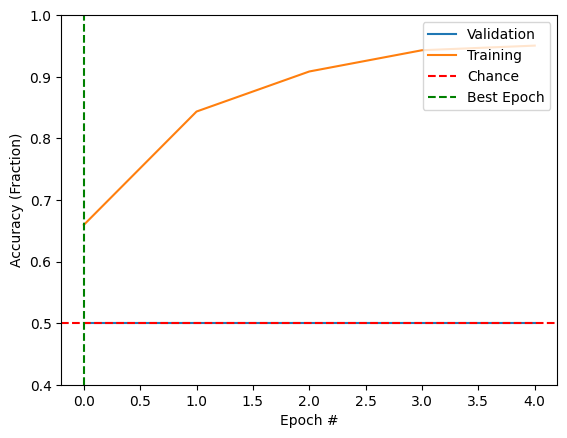

In [ ]:
transfer2 = TransferClassifier(name = 'ResNet50')
transfer2.fit(x_train, y_train, epochs = 5, validation_data = (x_test, y_test), shuffle = True, callbacks = [monitor])
plot_acc(transfer2.history)

In [ ]:
dec=transfer.evaluate(x_test, y_test, verbose=0)
print("VGG19:",dec)
dec1=transfer1.evaluate(x_test, y_test, verbose=0)
print("DENSENET121:",dec1)
dec2=transfer2.evaluate(x_test, y_test, verbose=0)
print("RESNET50:",dec2)

VGG19: [0.8109617829322815, 0.7699999809265137]
DENSENET121: [0.5837582945823669, 0.7549999952316284]
RESNET50: [22.41646957397461, 0.5]


In [ ]:
#@title Sample Solution { display-mode: "form" }
train_data, train_labels = get_train_data()
test_data, test_labels = get_test_data()
transfer = TransferClassifier(name = 'VGG16')
transfer.fit(train_data, train_labels, epochs = 10, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
plot_acc(transfer.history)

**This sample solution only uses VGG16. Now try using the other expert models.**

# **Milestone 5. Model Evaluation**



### Exercise (Coding)

Set your best model to the one you have trained (e.g., the transfer learning model).

In [ ]:
## Fill in the blank with the model that did best based on accuracy.
best_model = TransferClassifier(name='VGG19')

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Total accuracy does not reflect all that we want to know about a model's performance. It's just one metric out of many possible metrics for evaluating models.

In the case of pneumonia prediction, we may be more interested in other quantities, such as 'how accurate were we on the pneumonia category?' or 'how accurate were we on the normal category?' or 'how much of pneumonia were confused for normal?' or vice versa.



Our metrics for classification can be described in terms of a 'confusion matrix', shown below.

![Confusion Matrix](https://cdn-images-1.medium.com/max/1600/1*Z54JgbS4DUwWSknhDCvNTQ.png)

In a confusion matrix, we think in terms of 'actual' and 'predicted values'. If we take Pneumonia = 1/Positive and Normal = 0/Negative, then **what do TP, FP, TN, and FN mean?**

Answer:
1. TP: True positive (True pneumonia): Pneumonia predicted as pneumonia
2. TN: True negative (True normal): Normal predicted as normal
3. FP: False positive (False pneumonia): Normal mistaken as pneumonia
4. FN: False negative (False normal): Pneumonia mistaken as normal




The `sklearn` package makes calculating confusion matrices very quick. Its `metrics` submodule actually comes with a `confusion_matrix` tool. Let's start by grabbing that.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

To use `confusion_matrix`, we need:
* `labels`: the labels of the data (1 - PNEUMONIA or 0 - NORMAL)
* `predictions`: what our model thinks the labels are

To get `predictions`, you'll want to use ```best_model.predict_classes(test_data)```.

Please get the `predictions`, and use `accuracy_score` to print the overall test accuracy:

In [ ]:
#YOUR CODE HERE
model_predictions = (best_model.predict(x_test) > 0.5).astype("int32")
print('Model Accuracy: ', accuracy_score(y_test, model_predictions)*100.0)

13/13 [==============================] - 0s 24ms/step
Model Accuracy:  53.0


In [ ]:
#@title Sample Solution
predictions = (best_model.predict(test_data) > 0.5).astype("int32")
print('Accuracy: ', accuracy_score(test_labels, predictions)*100.0)

Now let's get our confusion matrix, and split it out into true positive, true negative, false positive, and false negative!

In [ ]:
confusion = confusion_matrix(y_test, predictions)
print(confusion)

[[200   0]
 [200   0]]


**How do you interpret each number?**

In [ ]:
tp  = confusion[1][1]
tn  = confusion[0][0]
fp = confusion[0][1]
fn = confusion[1][0]

print('True positive: %d'%tp)
print('True negative: %d'%tn)
print('False positive: %d'%fp)
print('False negative: %d'%fn)

True positive: 0
True negative: 200
False positive: 0
False negative: 200


We can visualize the confusion matrix with seaborn to make it easier for our eyes...

In [ ]:
# grab our plotting package
import seaborn as sns
import matplotlib.pyplot as plt

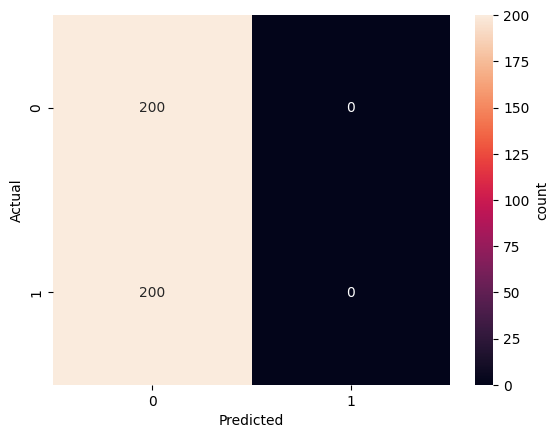

In [ ]:
sns.heatmap(confusion, annot = True, fmt = 'd', cbar_kws={'label':'count'});
plt.ylabel('Actual');
plt.xlabel('Predicted');

**Now that we have our confusion matrix, let's take a step back and think about these questions**

What did our model confuse more?
* PNEUMONIA for NORMAL or...
* NORMAL for PNEUMONIA

Why do you think it might have confused one for the other?

What is more problematic? False positives or False negatives?

Which of these metrics do we want to keep low?

# End!


To recap, we learned what neural network models are, learned how to create/build them, and explored different types of neural networks. By introducing convolutions and more complex methods to our networks (making the convolutional neural networks and expert models), we can improve our models quite a lot.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)